*Recommendation: this notebook should be run in colab for more efficiency.*

Datasets: https://github.com/Tiny-boot/Data_project

## **Libraries**

In [ ]:

!git clone https://github.com/Tiny-boot/Data_project


fatal: destination path 'Data_project' already exists and is not an empty directory.


In [ ]:
!ls Data_project

 Demography	 gtrends     README.md	 Temperatures   Wikipedia
'Google Trend'	 Influenza   rw		 Vaccinations


In [ ]:
!pip3 install wikipedia-api

In [ ]:
!pip install wikipedia

In [ ]:
!pip install Keras

In [ ]:
import requests
import datetime
import urllib.request
import csv
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import re
import wikipediaapi as wiki_api
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.cm as cm
from keras.callbacks import ReduceLROnPlateau

from pandas import DataFrame, concat, read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM
from numpy import concatenate
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import random
import os
import plotly.express as px



## **Datasets and cleaning**


### Demographic

*We are using the Annual Estimates of the Population for the U.S. per States, as well as Puerto Rico, provided by the Federal Reserve Bank of St. Louis, which has census records for all 50 states from 1900 to 2023.*

*These individual census records will be combined to calculate overall population density in the U.S. and identify states that may be more prone to faster disease spread.*

https://fred.stlouisfed.org/release?rid=118


In [ ]:
url = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Demography/fredgraph.csv"
demographic = pd.read_csv(url, sep=",")  # Change "," to "\t" for tab-separated values if needed
#demographic.set_index('DATE', inplace=True)
print(demographic)


           DATE      CAPOP      FLPOP      TXPOP      NYPOP     AZPOP  \
0    1900-01-01   1490.000    530.000   3055.000   7283.000   124.000   
1    1901-01-01   1550.000    544.000   3132.000   7449.000   131.000   
2    1902-01-01   1623.000    565.000   3210.000   7612.000   138.000   
3    1903-01-01   1702.000    587.000   3291.000   7771.000   144.000   
4    1904-01-01   1792.000    599.000   3374.000   7927.000   151.000   
..          ...        ...        ...        ...        ...       ...   
119  2019-01-01  39437.610  21492.056  28986.794  19463.131  7291.843   
120  2020-01-01  39503.200  21591.299  29234.361  20104.710  7186.683   
121  2021-01-01  39145.060  21830.708  29561.286  19854.526  7272.487   
122  2022-01-01  39040.616  22245.521  30029.848  19673.200  7365.684   
123  2023-01-01  38965.193  22610.726  30503.301  19571.216  7431.344   

        ALPOP     COPOP      GAPOP      ILPOP      MIPOP   BEASWPOP      NCPOP  
0    1830.000   543.000   2220.000   4828.

In [ ]:
demographic.columns

Index(['DATE', 'CAPOP', 'FLPOP', 'TXPOP', 'NYPOP', 'AZPOP', 'ALPOP', 'COPOP',
       'GAPOP', 'ILPOP', 'MIPOP', 'BEASWPOP', 'NCPOP'],
      dtype='object')

<ipython-input-520-65a1ca6250e7>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-520-65a1ca6250e7>:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



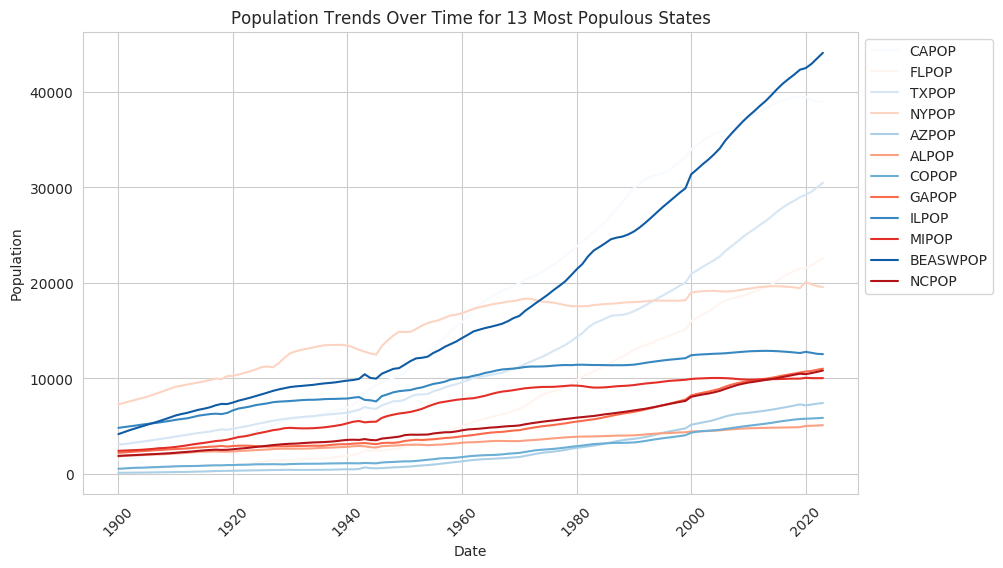

In [ ]:
states = ['CAPOP', 'FLPOP', 'TXPOP', 'NYPOP', 'AZPOP', 'ALPOP', 'COPOP',
          'GAPOP', 'ILPOP', 'MIPOP', 'BEASWPOP', 'NCPOP']

reds = cm.get_cmap('Reds', len(states) // 2 + 1)
blues = cm.get_cmap('Blues', len(states) // 2 + 1)

demographic["DATE"] = pd.to_datetime(demographic["DATE"])
colors = []
for i in range(len(states)):
    if i % 2 == 0:  # Even indices get blue shades
        colors.append(blues(i // 2))
    else:  # Odd indices get red shades
        colors.append(reds(i // 2))

# Create the plot
plt.figure(figsize=(10, 6))

for i, state in enumerate(states):
    plt.plot(demographic["DATE"], demographic[state], label=state, color=colors[i])

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only year on x-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Population Trends Over Time for 13 Most Populous States')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend outside the plot
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# state areas (in square miles) - Data from wikipedia
state_areas = {
    "CAPOP": 163695,  # California
    "FLPOP": 65758,   # Florida
    "TXPOP": 268596,  # Texas
    "NYPOP": 54556,   # New York
    "AZPOP": 113990,  # Arizona
    "ALPOP": 52420,   # Alabama
    "COPOP": 104094,  # Colorado
    "GAPOP": 59425,   # Georgia
    "ILPOP": 57914,   # Illinois
    "MIPOP": 96714,   # Michigan
    "BEASWPOP": 77522,  # Example region (adjust accordingly)
    "NCPOP": 53819,   # North Carolina
}

# Select the latest year (2023)
latest_data = demographic[demographic["DATE"] == "2023-01-01"].iloc[0]

# Calculate population density
density_data = {
    state: latest_data[state] / state_areas[state]
    for state in state_areas.keys()
}

# Prepare data for Plotly
df_density = pd.DataFrame({
    "State": list(state_areas.keys()),
    "PopulationDensity": list(density_data.values())
})

# Add state abbreviations for mapping
state_abbreviations = {
    "CAPOP": "CA", "FLPOP": "FL", "TXPOP": "TX", "NYPOP": "NY", "AZPOP": "AZ",
    "ALPOP": "AL", "COPOP": "CO", "GAPOP": "GA", "ILPOP": "IL", "MIPOP": "MI",
    "BEASWPOP": "BE", "NCPOP": "NC"
}
df_density["Abbreviation"] = df_density["State"].map(state_abbreviations)

# Create the choropleth map
fig = px.choropleth(
    df_density,
    locations="Abbreviation",
    locationmode="USA-states",
    color="PopulationDensity",
    hover_name="Abbreviation",
    color_continuous_scale="Reds",
    scope="usa"
)

fig.update_layout(
    title_text="Population Density of US States (2023)",
    title_x=0.5,
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type="albers usa"
    )
)

fig.show()


### Hospitals

*Comprehensive weekly U.S. surveillance reports, which in 2023 included data from 3,400 healthcare providers across 50 states and over 110 million patient visits. And weekly Influenza data from the Health departement of California.*

https://data.chhs.ca.gov/dataset/influenza-surveillance

https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html


In [ ]:
url2 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Influenza/califluweekly.csv"
ili_flu_cali = pd.read_csv(url2, sep=",")

In [ ]:
california_data = ili_flu_cali[ili_flu_cali['region'] == 'California']

In [ ]:
california_data

,_id,season,date_code,weekending,region,Total_ILI,Total_Patients_Seen,Percent_ILI,Number_Providers_Reporting
1,2,2001-2002,200140,10/6/2001,California,25,1211,2.06,14
7,8,2001-2002,200141,10/13/2001,California,38,1845,2.06,19
13,14,2001-2002,200142,10/20/2001,California,80,2996,2.67,29
19,20,2001-2002,200143,10/27/2001,California,79,3048,2.59,30
25,26,2001-2002,200144,11/3/2001,California,105,3015,3.48,30
...,...,...,...,...,...,...,...,...,...
5917,5918,2019-2020,202035,8/29/2020,California,430,52568,0.82,96
5923,5924,2019-2020,202036,9/5/2020,California,414,52460,0.79,96
5929,5930,2019-2020,202037,9/12/2020,California,417,49104,0.85,91
5935,5936,2019-2020,202038,9/19/2020,California,426,54111,0.79,101


In [ ]:
california_data=california_data.reset_index()

In [ ]:
week = []
value = 38


for i in range(991):
    week.append(value)
    if value < 52:
        value = value + 1
    else:
        value = 1


print(len(week))


california_data["WEEK"] = week



991


In [ ]:
california_data

,index,_id,season,date_code,weekending,region,Total_ILI,Total_Patients_Seen,Percent_ILI,Number_Providers_Reporting,WEEK
0,1,2,2001-2002,200140,10/6/2001,California,25,1211,2.06,14,38
1,7,8,2001-2002,200141,10/13/2001,California,38,1845,2.06,19,39
2,13,14,2001-2002,200142,10/20/2001,California,80,2996,2.67,29,40
3,19,20,2001-2002,200143,10/27/2001,California,79,3048,2.59,30,41
4,25,26,2001-2002,200144,11/3/2001,California,105,3015,3.48,30,42
...,...,...,...,...,...,...,...,...,...,...,...
986,5917,5918,2019-2020,202035,8/29/2020,California,430,52568,0.82,96,36
987,5923,5924,2019-2020,202036,9/5/2020,California,414,52460,0.79,96,37
988,5929,5930,2019-2020,202037,9/12/2020,California,417,49104,0.85,91,38
989,5935,5936,2019-2020,202038,9/19/2020,California,426,54111,0.79,101,39


In [ ]:
first_column = california_data.pop('WEEK')



california_data.insert(0, 'WEEK', first_column)

In [ ]:
california_data.set_index('season', inplace=True)

In [ ]:
california_data.drop(["_id","date_code"],axis=1, inplace=True)

In [ ]:

california_data['weekending'] = pd.to_datetime(california_data['weekending'])
california_data['YEAR'] = california_data['weekending'].dt.year


In [ ]:
california_data

,WEEK,index,weekending,region,Total_ILI,Total_Patients_Seen,Percent_ILI,Number_Providers_Reporting,YEAR
season,,,,,,,,,
2001-2002,38,1,2001-10-06,California,25,1211,2.06,14,2001
2001-2002,39,7,2001-10-13,California,38,1845,2.06,19,2001
2001-2002,40,13,2001-10-20,California,80,2996,2.67,29,2001
2001-2002,41,19,2001-10-27,California,79,3048,2.59,30,2001
2001-2002,42,25,2001-11-03,California,105,3015,3.48,30,2001
...,...,...,...,...,...,...,...,...,...
2019-2020,36,5917,2020-08-29,California,430,52568,0.82,96,2020
2019-2020,37,5923,2020-09-05,California,414,52460,0.79,96,2020
2019-2020,38,5929,2020-09-12,California,417,49104,0.85,91,2020


In [ ]:
# Using the https://data.chhs.ca.gov/dataset/influenza-surveillance california weekly data set

url1 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Influenza/ILINet.csv"
ili_flu = pd.read_csv(url1, sep=",",skiprows= 1)

In [ ]:
ili_flu

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,Alabama,2010,40,X,2.13477,X,X,X,X,X,X,249,35,11664
1,States,Alaska,2010,40,X,0.875146,X,X,X,X,X,X,15,7,1714
2,States,Arizona,2010,40,X,0.674721,X,X,X,X,X,X,172,49,25492
3,States,Arkansas,2010,40,X,0.696056,X,X,X,X,X,X,18,15,2586
4,States,California,2010,40,X,1.95412,X,X,X,X,X,X,632,112,32342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39688,States,Wyoming,2024,43,X,1.08178,X,X,X,X,X,X,25,12,2311
39689,States,Commonwealth of the Northern Mariana Islands,2024,43,X,X,X,X,X,X,X,X,X,X,X
39690,States,Puerto Rico,2024,43,X,1.70316,X,X,X,X,X,X,21,4,1233
39691,States,Virgin Islands,2024,43,X,1.08499,X,X,X,X,X,X,12,4,1106


In [ ]:
ili_flu_cal = ili_flu[ili_flu["REGION"] == 'California']


In [ ]:

ili_flu_cal.replace("X", np.nan, inplace=True)
ili_flu_cal=ili_flu_cal.dropna(axis=1)

<ipython-input-536-144c68af2e40>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
first_column = ili_flu_cal.pop('WEEK')



ili_flu_cal.insert(0, 'WEEK', first_column)

In [ ]:
ili_flu_cal['weekending'] = pd.to_datetime(ili_flu_cal['YEAR'].astype(str) + ' ' + ili_flu_cal['WEEK'].astype(str).str.zfill(2) + ' 1',
                                       format='%Y %W %w')


In [ ]:
ili_flu_cal['ILITOTAL'] = pd.to_numeric(ili_flu_cal['ILITOTAL'], errors='coerce')


In [ ]:
ili_flu_cal = ili_flu_cal.drop(["REGION TYPE","REGION","%UNWEIGHTED ILI","NUM. OF PROVIDERS"],axis=1)

In [ ]:
california_data=california_data.drop(["index","region","Percent_ILI","Number_Providers_Reporting"],axis=1)

In [ ]:
ili_flu_cal.dtypes

,0
WEEK,int64
YEAR,int64
ILITOTAL,int64
TOTAL PATIENTS,object
weekending,datetime64[ns]


In [ ]:
california_data.dtypes

,0
WEEK,int64
weekending,datetime64[ns]
Total_ILI,int64
Total_Patients_Seen,int64
YEAR,int32


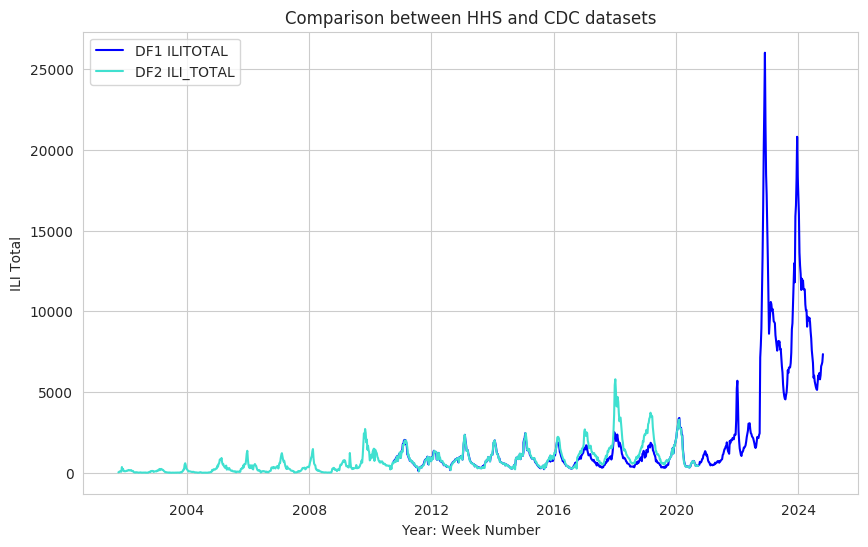

In [ ]:
plt.figure(figsize=(10, 6))

# Plot ILITOTAL from df1
plt.plot(ili_flu_cal['weekending'], ili_flu_cal['ILITOTAL'], label='DF1 ILITOTAL', color='blue')

# Plot ILI_TOTAL from df2
plt.plot(california_data['weekending'], california_data['Total_ILI'], label='DF2 ILI_TOTAL', color='turquoise')

# Add labels and title
plt.xlabel('Year: Week Number')
plt.ylabel('ILI Total')
plt.title('Comparison between HHS and CDC datasets')
plt.legend()

# Show the plot
plt.show()


*We can see that there is a discrepancy between the dataset from the californian state and the CDC.This is due to the fact that the CDC data also includes patients from clinics and HHS. Because we need to merge the datasets we are going to calculate the mean of the two time series when there is discrenpancy to be able to combine them.*

In [ ]:
#merged two dataframes
ili_flu_cal = ili_flu_cal.rename(columns={
    'ILITOTAL': 'Total_ILI',
    'TOTAL PATIENTS': 'Total_Patients_Seen'
})



In [ ]:
ili_flu_cal

,WEEK,YEAR,Total_ILI,Total_Patients_Seen,weekending
4,40,2010,632,32342,2010-10-04
56,41,2010,742,34469,2010-10-11
108,42,2010,766,34170,2010-10-18
160,43,2010,666,34733,2010-10-25
212,44,2010,887,35153,2010-11-01
...,...,...,...,...,...
39422,39,2024,6036,274320,2024-09-23
39477,40,2024,6605,302870,2024-09-30
39532,41,2024,6709,299268,2024-10-07
39587,42,2024,6857,296515,2024-10-14


In [ ]:
california_data

,WEEK,weekending,Total_ILI,Total_Patients_Seen,YEAR
season,,,,,
2001-2002,38,2001-10-06,25,1211,2001
2001-2002,39,2001-10-13,38,1845,2001
2001-2002,40,2001-10-20,80,2996,2001
2001-2002,41,2001-10-27,79,3048,2001
2001-2002,42,2001-11-03,105,3015,2001
...,...,...,...,...,...
2019-2020,36,2020-08-29,430,52568,2020
2019-2020,37,2020-09-05,414,52460,2020
2019-2020,38,2020-09-12,417,49104,2020


In [ ]:
merged = pd.merge(california_data, ili_flu_cal, on='weekending', how='outer', suffixes=('_df1', '_df2'))
merged['Total_Patients_Seen_df2'] = pd.to_numeric(merged['Total_Patients_Seen_df2'], errors='coerce')

merged['ILI'] = merged[['Total_ILI_df1', 'Total_ILI_df2']].mean(axis=1, skipna=True)
merged['Total_patients'] = merged[['Total_Patients_Seen_df1', 'Total_Patients_Seen_df2']].mean(axis=1, skipna=True)
merged['WEEK'] = merged[['WEEK_df1', 'WEEK_df2']].mean(axis=1, skipna=True)
merged = merged.drop(columns=['Total_Patients_Seen_df1', 'Total_Patients_Seen_df2','Total_ILI_df1','Total_ILI_df2','WEEK_df1','WEEK_df2','YEAR_df2','YEAR_df1'])

In [ ]:
merged

,weekending,ILI,Total_patients,WEEK
0,2001-10-06,25.0,1211.0,38.0
1,2001-10-13,38.0,1845.0,39.0
2,2001-10-20,80.0,2996.0,40.0
3,2001-10-27,79.0,3048.0,41.0
4,2001-11-03,105.0,3015.0,42.0
...,...,...,...,...
1720,2024-09-23,6036.0,274320.0,39.0
1721,2024-09-30,6605.0,302870.0,40.0
1722,2024-10-07,6709.0,299268.0,41.0
1723,2024-10-14,6857.0,296515.0,42.0


In [ ]:
merged.rename(columns={'weekending': 'Date'}, inplace=True)

<Axes: xlabel='Date'>

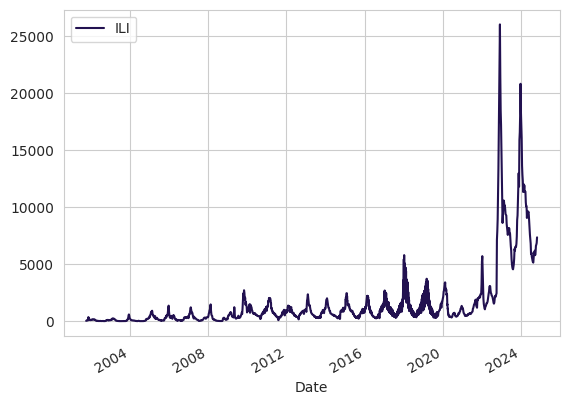

In [ ]:
merged.plot(x='Date',y='ILI')

### Vaccine coverage

https://data.cdc.gov/Flu-Vaccinations/Influenza-Vaccination-Coverage-for-All-Ages-6-Mont/vh55-3he6/data_preview

In [ ]:
url2 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Vaccinations/Influenza_Vaccination_Coverage_for_All_Ages__6__Months__20241105.csv"
vaccines = pd.read_csv(url2, sep=",")

In [ ]:
vaccines.head()

,Vaccine,Geography Type,Geography,FIPS,Season/Survey Year,Month,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
0,Seasonal Influenza,States/Local Areas,TX-Bexar County,151,2017-18,1,6 Months - 17 Years,Medical Setting,88.9,86.3 to 91.1,1060.0
1,Seasonal Influenza,States/Local Areas,TX-Bexar County,151,2020-21,1,6 Months - 17 Years,Medical Setting,79.1,75.9 to 82.0,1253.0
2,Seasonal Influenza,States/Local Areas,TX-Bexar County,151,2017-18,1,6 Months - 17 Years,Pharmacy/Store,8.4,6.5 to 10.8,1060.0
3,Seasonal Influenza,States/Local Areas,TX-Bexar County,151,2020-21,1,6 Months - 17 Years,Pharmacy/Store,18.2,15.5 to 21.3,1253.0
4,Seasonal Influenza,States/Local Areas,TX-Bexar County,151,2018-19,1,Age,50-64 Years,46.8,32.1 to 61.5 ‡,115.0


In [ ]:
vaccines = vaccines.sort_values(by=['Season/Survey Year', 'Month'])


In [ ]:
vaccines.head(10)

,Vaccine,Geography Type,Geography,FIPS,Season/Survey Year,Month,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
1224,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Age,>=6 Months,47.0,45.9 to 48.1,54853.0
1241,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Age,6 Months - 17 Years,52.3,49.0 to 55.6,14178.0
1251,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Age,>=18 Years,45.2,44.2 to 46.2,40675.0
1267,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Race and Ethnicity,Hispanic,41.4,37.3 to 45.5,2744.0
1278,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Age,18-49 Years not at High Risk,33.3,31.6 to 35.0,11027.0
1288,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Age,18-49 Years at High Risk,44.9,41.3 to 48.5,2642.0
1290,Seasonal Influenza,HHS Regions/National,Region 1,101,2009-10,1,Race and Ethnicity,"Other or Multiple Races, Non-Hispanic",45.6,40.3 to 50.9,1144.0
3199,Influenza A (H1N1) 2009 Monovalent,States/Local Areas,Oklahoma,40,2009-10,1,Race and Ethnicity,Hispanic,24.5,19.6 to 29.4,637.0
3239,Influenza A (H1N1) 2009 Monovalent,States/Local Areas,Oklahoma,40,2009-10,1,Race and Ethnicity,"White, Non-Hispanic",21.2,19.4 to 23.0,6266.0
3246,Influenza A (H1N1) 2009 Monovalent,States/Local Areas,Oklahoma,40,2009-10,1,Race and Ethnicity,"Other or Multiple Races, Non-Hispanic",19.9,14.7 to 25.1,553.0


In [ ]:
vaccines_cal = vaccines[(vaccines["Geography"] == 'Region 9') | (vaccines["Geography"] == 'California')]


In [ ]:
vaccines_cal.head(10)

,Vaccine,Geography Type,Geography,FIPS,Season/Survey Year,Month,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
40375,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years not in Initial Target Group,14.9,13.6 to 16.2,10649.0
40412,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years at High Risk,23.9,21.4 to 26.4,3965.0
40462,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=18 Years,19.3,18.4 to 20.2,24852.0
40471,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=6 Months,23.9,23.0 to 24.8,38249.0
40481,"Any Influenza Vaccination, Seasonal or H1N1",HHS Regions/National,Region 9,109,2009-10,1,Race and Ethnicity,"Other or Multiple Races, Non-Hispanic",46.8,42.2 to 51.4,3998.0
40514,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,6 Months - 64 Years at High Risk (Initial Targ...,30.2,28.8 to 31.6,20345.0
40551,"Any Influenza Vaccination, Seasonal or H1N1",HHS Regions/National,Region 9,109,2009-10,1,Race and Ethnicity,"White, Non-Hispanic",44.6,43.4 to 45.8,24640.0
40567,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,6 Months - 17 Years,36.4,34.4 to 38.4,13397.0
40572,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Race and Ethnicity,"American Indian or Alaska Native, Non-Hispanic",35.4,27.3 to 43.5,463.0
40632,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Race and Ethnicity,"Asian, Non-Hispanic",32.0,27.8 to 36.2,3839.0


In [ ]:

vaccines_cal_age = vaccines_cal[~vaccines_cal['Dimension Type'].str.startswith('Race and Ethnicity')]


In [ ]:
vaccines_cal_age

,Vaccine,Geography Type,Geography,FIPS,Season/Survey Year,Month,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
40375,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years not in Initial Target Group,14.9,13.6 to 16.2,10649.0
40412,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years at High Risk,23.9,21.4 to 26.4,3965.0
40462,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=18 Years,19.3,18.4 to 20.2,24852.0
40471,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=6 Months,23.9,23.0 to 24.8,38249.0
40514,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,6 Months - 64 Years at High Risk (Initial Targ...,30.2,28.8 to 31.6,20345.0
...,...,...,...,...,...,...,...,...,...,...,...
217539,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-49 Years not at High Risk,25.9,23.4 to 28.4,4901.0
217555,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-64 Years not at High Risk,27.7,25.5 to 29.9,7221.0
217566,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-49 Years,26.5,24.1 to 28.9,6038.0
217583,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,50-64 Years,37.0,33.5 to 40.5,3818.0


In [ ]:
vaccines_cal_age.dtypes


,0
Vaccine,object
Geography Type,object
Geography,object
FIPS,int64
Season/Survey Year,object
Month,int64
Dimension Type,object
Dimension,object
Estimate (%),object
95% CI (%),object


In [ ]:
vaccines_cal_age['Year'] = vaccines_cal_age['Season/Survey Year'].str[:4]

<ipython-input-561-85f48cb9ffe3>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
vaccines_cal_age

,Vaccine,Geography Type,Geography,FIPS,Season/Survey Year,Month,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size,Year
40375,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years not in Initial Target Group,14.9,13.6 to 16.2,10649.0,2009
40412,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years at High Risk,23.9,21.4 to 26.4,3965.0,2009
40462,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=18 Years,19.3,18.4 to 20.2,24852.0,2009
40471,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=6 Months,23.9,23.0 to 24.8,38249.0,2009
40514,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,6 Months - 64 Years at High Risk (Initial Targ...,30.2,28.8 to 31.6,20345.0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...
217539,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-49 Years not at High Risk,25.9,23.4 to 28.4,4901.0,2023
217555,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-64 Years not at High Risk,27.7,25.5 to 29.9,7221.0,2023
217566,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-49 Years,26.5,24.1 to 28.9,6038.0,2023
217583,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,50-64 Years,37.0,33.5 to 40.5,3818.0,2023


In [ ]:
vaccines_cal_age['Estimate (%)'] = pd.to_numeric(vaccines_cal_age['Estimate (%)'], errors='coerce')


<ipython-input-563-c98ac46d5a60>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
vaccines_cal_age['Vaccination'] = ((vaccines_cal_age["Estimate (%)"])*vaccines_cal_age["Sample Size"])/100

<ipython-input-564-824709fd95ff>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
vaccines_cal_age

,Vaccine,Geography Type,Geography,FIPS,Season/Survey Year,Month,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size,Year,Vaccination
40375,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years not in Initial Target Group,14.9,13.6 to 16.2,10649.0,2009,1586.701
40412,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,25-64 Years at High Risk,23.9,21.4 to 26.4,3965.0,2009,947.635
40462,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=18 Years,19.3,18.4 to 20.2,24852.0,2009,4796.436
40471,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,>=6 Months,23.9,23.0 to 24.8,38249.0,2009,9141.511
40514,Influenza A (H1N1) 2009 Monovalent,HHS Regions/National,Region 9,109,2009-10,1,Age,6 Months - 64 Years at High Risk (Initial Targ...,30.2,28.8 to 31.6,20345.0,2009,6144.190
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217539,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-49 Years not at High Risk,25.9,23.4 to 28.4,4901.0,2023,1269.359
217555,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-64 Years not at High Risk,27.7,25.5 to 29.9,7221.0,2023,2000.217
217566,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,18-49 Years,26.5,24.1 to 28.9,6038.0,2023,1600.070
217583,Seasonal Influenza,HHS Regions/National,Region 9,109,2023-24,12,Age,50-64 Years,37.0,33.5 to 40.5,3818.0,2023,1412.660


In [ ]:
vaccines_cal_month=vaccines_cal_age.groupby(['Geography','Year','Month'])['Vaccination'].sum().reset_index()

In [ ]:
vaccines_cal_month.head(5)

,Geography,Year,Month,Vaccination
0,California,2009,1,48581.772
1,California,2009,2,52150.901
2,California,2009,3,53622.736
3,California,2009,4,54317.675
4,California,2009,5,54940.225


In [ ]:
vaccines_cal_month['Date'] = pd.to_datetime(vaccines_cal_month['Year'].astype(str) + '-' + vaccines_cal_month['Month'].astype(str) + '-01')

In [ ]:
#weekly_data = pd.DataFrame({"Date": combined_df.loc[combined_df['weekending'] > '2008-12-31', 'weekending']})



In [ ]:
#weekly_data

In [ ]:
"""weekly_data = weekly_data.sort_values("Date")
vaccines_cal_month = vaccines_cal_month.sort_values("Date")

weekly_data = pd.merge_asof(
    weekly_data,
    vaccines_cal_month[["Date", "Vaccination"]],
    on="Date",
    direction="backward"
)"""

'weekly_data = weekly_data.sort_values("Date")\nvaccines_cal_month = vaccines_cal_month.sort_values("Date")\n\nweekly_data = pd.merge_asof(\n    weekly_data,\n    vaccines_cal_month[["Date", "Vaccination"]],\n    on="Date",\n    direction="backward"\n)'

In [ ]:
url3 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Vaccinations/Weekly_Cumulative_Influenza_Vaccination_Coverage__Adults_18_and_Older__United_States_20241030.csv"
weekly1 = pd.read_csv(url3)

In [ ]:
weekly_cal =weekly1[(weekly1["Geographic_Name"] == 'California') ]
weekly_cal=weekly_cal.drop(["Indicator_Label","Indicator_Category_Label","Week_Ending","Legend","Indicator_Category_Label_Sort","Demographic_Level_Sort","Demographic_Name_Sort","Geographic_Sort","Season_Sort","Legend_Sort","Geographic_Level"],axis=1)

In [ ]:
weekly_cal

,Geographic_Name,Demographic_Level,Demographic_Name,Month_Week,ND_Weekly_Estimate,CI_Half_width_95pct,n_unweighted,Suppression_Flag,Current_Season_Week_Ending,Influenza_Season,95 CI (%)
10,California,Overall,18+ years,January Week 4,29.0,5.7422,429.0,0.0,01/27/2024 12:00:00 AM,2023-2024,23.2 - 34.7
11,California,Overall,18+ years,January Week 4,4.6,2.9988,429.0,0.0,01/27/2024 12:00:00 AM,2023-2024,1.6 - 7.6
12,California,Overall,18+ years,January Week 4,21.5,5.3910,429.0,0.0,01/27/2024 12:00:00 AM,2023-2024,16.1 - 26.9
13,California,Overall,18+ years,January Week 4,44.9,2.1963,10003.0,0.0,01/27/2024 12:00:00 AM,2023-2024,42.7 - 47.1
14,California,Overall,18+ years,January Week 4,44.9,2.1963,10003.0,0.0,01/27/2024 12:00:00 AM,2023-2024,42.7 - 47.1
...,...,...,...,...,...,...,...,...,...,...,...
16849,California,Overall,18+ years,March Week 4,11.6,5.5592,241.0,0.0,03/23/2024 12:00:00 AM,2023-2024,6.1 - 17.2
16850,California,Overall,18+ years,March Week 4,49.5,2.2221,10003.0,0.0,03/23/2024 12:00:00 AM,2023-2024,47.3 - 51.7
16851,California,Overall,18+ years,March Week 4,49.5,2.2221,10003.0,0.0,03/23/2024 12:00:00 AM,2023-2024,47.3 - 51.7
17262,California,Overall,18+ years,April Week 3,51.4,2.4457,10003.0,0.0,04/20/2024 12:00:00 AM,2023-2024,49.0 - 53.8


In [ ]:
weekly_cal['Vaccination'] = ((weekly_cal["ND_Weekly_Estimate"])*weekly_cal["n_unweighted"])/100

In [ ]:
weekly_cal=weekly_cal.groupby(['Month_Week','Current_Season_Week_Ending'])['Vaccination'].sum().reset_index()

In [ ]:

# Group weekly data by month to get total vaccinations per month in 2024
weekly_cal['Month'] = pd.to_datetime(weekly_cal['Current_Season_Week_Ending']).dt.month
weekly_cal['Year'] = pd.to_datetime(weekly_cal['Current_Season_Week_Ending']).dt.year

# Calculate monthly totals for 2024
monthly_totals_2024 = weekly_cal.groupby('Month')['Vaccination'].sum()

# Calculate weekly proportions for each month in 2024
weekly_cal = weekly_cal.merge(monthly_totals_2024, on='Month', suffixes=('', '_MonthlyTotal'))
weekly_cal['Weekly_Proportion'] = weekly_cal['Vaccination'] / weekly_cal['Vaccination_MonthlyTotal']

# Create a dictionary to store the weekly patterns for each month
weekly_patterns = weekly_cal.groupby('Month')['Weekly_Proportion'].apply(list).to_dict()


<ipython-input-577-a7178b453c16>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-577-a7178b453c16>:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
weekly_patterns

{1: [0.04526546901496358,
  0.23916173925160383,
  0.23779640489871473,
  0.23648671408441868,
  0.24128967275029914],
 2: [0.042972997142509455,
  0.24151944525606178,
  0.2381819552469219,
  0.2386067348504901,
  0.23871886750401675],
 3: [0.031674093666690745,
  0.1936402836167414,
  0.19340874049762408,
  0.19480574952875276,
  0.19374697126428128,
  0.19272416142590978],
 4: [0.07430444332488079,
  0.23142388916877982,
  0.23142388916877982,
  0.23142388916877982,
  0.23142388916877982],
 5: [0.15367523093000185, 0.4231623845349991, 0.4231623845349991],
 6: [1.0],
 9: [1.0],
 10: [0.03816411671263725,
  0.1830365747736241,
  0.23258816408511443,
  0.26575776503768966,
  0.2804533793909346],
 11: [0.03296339170861983,
  0.2195314170312371,
  0.2372407489463065,
  0.24953423111315565,
  0.2607302112006809],
 12: [0.03940792240250457,
  0.187592065439126,
  0.19405915149925032,
  0.1912071838645606,
  0.1925187623605416,
  0.19521491443401692]}

As we can see the CDC datasets has multiple weeks missing so we need to use another dataset instead.

In [ ]:
url4 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Vaccinations/Weekly_Influenza_Vaccination_Coverage_and_Intent_for_Vaccination__Overall__by_Selected_Demographics_and_Jurisdiction__Among_Adults_18_Years_and_Older_20241119.csv"

weekly = pd.read_csv(url4)

In [ ]:
weekly.head(10)

,Vaccine,Geographic Level,Geographic Name,Demographic Level,Demographic Name,indicator_label,indicator_category_label,Month_Week,Week_ending,Estimates,CI_Half_width_95pct,Unweighted Sample Size,Current_Season_Week_Ending,Influenza_Season,suppression_flag
0,FLU,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,01/27/2024 12:00:00 AM,30.8,7.8741,159.0,01/25/2025 12:00:00 AM,2023-2024,0
1,FLU,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,01/27/2024 12:00:00 AM,6.8,4.1646,159.0,01/25/2025 12:00:00 AM,2023-2024,0
2,FLU,State,Arizona,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,01/27/2024 12:00:00 AM,22.3,7.6092,159.0,01/25/2025 12:00:00 AM,2023-2024,0
3,FLU,State,Arizona,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,01/27/2024 12:00:00 AM,40.1,1.8569,8960.0,01/25/2025 12:00:00 AM,2023-2024,0
4,FLU,State,Arizona,Overall,18+ years,Up-to-date,Yes,January Week 4,01/27/2024 12:00:00 AM,40.1,1.8569,8960.0,01/25/2025 12:00:00 AM,2023-2024,0
5,FLU,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,01/27/2024 12:00:00 AM,43.8,10.9792,88.0,01/25/2025 12:00:00 AM,2023-2024,0
6,FLU,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,01/27/2024 12:00:00 AM,2.9,2.1375,88.0,01/25/2025 12:00:00 AM,2023-2024,0
7,FLU,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,01/27/2024 12:00:00 AM,12.9,6.6902,88.0,01/25/2025 12:00:00 AM,2023-2024,0
8,FLU,State,Arkansas,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,01/27/2024 12:00:00 AM,40.5,1.8521,7139.0,01/25/2025 12:00:00 AM,2023-2024,0
9,FLU,State,Arkansas,Overall,18+ years,Up-to-date,Yes,January Week 4,01/27/2024 12:00:00 AM,40.5,1.8521,7139.0,01/25/2025 12:00:00 AM,2023-2024,0


In [ ]:
weekly['Week_ending'] = pd.to_datetime(weekly['Week_ending'], format='%m/%d/%Y %I:%M:%S %p')

# Extract year and month into separate columns
weekly['year'] = weekly['Week_ending'].dt.year
weekly['month'] = weekly['Week_ending'].dt.month

In [ ]:
weekly=weekly[(weekly["Geographic Name"] == 'California') ]

In [ ]:
weekly=weekly.drop(["indicator_label","indicator_category_label","Current_Season_Week_Ending","Demographic Level","Geographic Level","Vaccine"],axis=1)

In [ ]:
weekly['Vaccination'] = ((weekly["Estimates"])*weekly["Unweighted Sample Size"])/100

In [ ]:
weekly=weekly.reset_index()

In [ ]:
weekly=weekly.groupby(['month','Month_Week'])['Vaccination'].sum().reset_index()

In [ ]:
weekly

,month,Month_Week,Vaccination
0,1,January,1729.480
1,1,January Week 1,11439.880
2,1,January Week 2,11386.963
3,1,January Week 3,11335.753
4,1,January Week 4,11550.924
5,2,February,1726.084
6,2,February Week 1,12074.068
7,2,February Week 2,11935.440
8,2,February Week 3,11952.848
9,2,February Week 4,11957.505


In [ ]:
weekly['monthly_total'] = weekly.groupby('month')['Vaccination'].transform('sum')

# Step 2: Calculate weekly weight
weekly['weight'] = weekly['Vaccination'] / weekly['monthly_total']

# Step 3: Filter weekly rows
weekly_weights = weekly[weekly['Month_Week'].str.contains('Week')]

# Step 4: Group by month and collect weights as arrays
weights_dict = weekly_weights.groupby('month')['weight'].apply(list).to_dict()



In [ ]:
weekly_patterns

{1: [0.04526546901496358,
  0.23916173925160383,
  0.23779640489871473,
  0.23648671408441868,
  0.24128967275029914],
 2: [0.042972997142509455,
  0.24151944525606178,
  0.2381819552469219,
  0.2386067348504901,
  0.23871886750401675],
 3: [0.031674093666690745,
  0.1936402836167414,
  0.19340874049762408,
  0.19480574952875276,
  0.19374697126428128,
  0.19272416142590978],
 4: [0.07430444332488079,
  0.23142388916877982,
  0.23142388916877982,
  0.23142388916877982,
  0.23142388916877982],
 5: [0.15367523093000185, 0.4231623845349991, 0.4231623845349991],
 6: [1.0],
 9: [1.0],
 10: [0.03816411671263725,
  0.1830365747736241,
  0.23258816408511443,
  0.26575776503768966,
  0.2804533793909346],
 11: [0.03296339170861983,
  0.2195314170312371,
  0.2372407489463065,
  0.24953423111315565,
  0.2607302112006809],
 12: [0.03940792240250457,
  0.187592065439126,
  0.19405915149925032,
  0.1912071838645606,
  0.1925187623605416,
  0.19521491443401692]}

In [ ]:
weights_dict

{1: [0.24112893366776977,
  0.24001355310583225,
  0.2389341525620218,
  0.2434695107813587],
 2: [0.24320350836306973,
  0.24041117557536673,
  0.24076181851307293,
  0.24085562275025682],
 3: [0.19471765980767758,
  0.194603260652197,
  0.19586909170272718,
  0.19497738105172002,
  0.19410830535985157],
 4: [0.234666024731043,
  0.234666024731043,
  0.234666024731043,
  0.234666024731043],
 5: [0.23234132295269896,
  0.23327629809536574,
  0.23327629809536574,
  0.23327629809536574],
 6: [0.1903299192821511,
  0.1903299192821511,
  0.1903299192821511,
  0.1903299192821511,
  0.1903299192821511],
 8: [0.5089661941172117, 0.4910338058827884],
 9: [0.5207975483333964,
  0.07127444268172026,
  0.12301184319160306,
  0.12940139303008144,
  0.1555147727631989],
 10: [0.05452653527629016,
  0.20061810565158697,
  0.24375778153050293,
  0.27359477421587813,
  0.20566737398329027],
 11: [0.2758822596713729,
  0.22215686869930912,
  0.2337140500628552,
  0.2442849223866499],
 12: [0.1885452974

In [ ]:
def distribute_monthly_to_weekly(monthly_value, month, weekly_pattern):
    """
    Distribute the monthly value into weekly values based on the weekly pattern for the month.
    """
    weekly_values = np.array(weekly_pattern) * monthly_value
    return weekly_values

# Convert monthly data to weekly using the 2024 patterns
def convert_to_weekly_with_patterns(monthly_data, weekly_patterns):
    weekly_data = []

    for index, row in monthly_data.iterrows():
        # Extract the month and monthly vaccination count
        month = row['Month']
        monthly_value = row['Vaccination']

        # Get the weekly pattern for this month from the 2024 data
        if month in weekly_patterns:
            weekly_pattern = weekly_patterns[month]
            num_weeks = len(weekly_pattern)  # Number of weeks in pattern

            # Distribute the monthly vaccination value across weeks based on the pattern
            weekly_values = distribute_monthly_to_weekly(monthly_value, month, weekly_pattern)

            # Generate weekly dates within the month
            weekly_dates = pd.date_range(start=row['Date'], periods=num_weeks, freq='W')
            weekly_data.extend(zip(weekly_dates, weekly_values))

    # Create DataFrame for the weekly data
    return pd.DataFrame(weekly_data, columns=['Date', 'Vaccination']).set_index('Date')

# Apply to monthly data
weekly_data_2009_2023 = convert_to_weekly_with_patterns(vaccines_cal_month, weekly_patterns)


In [ ]:
vaccines_cal_month

,Geography,Year,Month,Vaccination,Date
0,California,2009,1,48581.772,2009-01-01
1,California,2009,2,52150.901,2009-02-01
2,California,2009,3,53622.736,2009-03-01
3,California,2009,4,54317.675,2009-04-01
4,California,2009,5,54940.225,2009-05-01
...,...,...,...,...,...
319,Region 9,2023,8,4131.462,2023-08-01
320,Region 9,2023,9,13264.721,2023-09-01
321,Region 9,2023,10,29245.225,2023-10-01
322,Region 9,2023,11,38269.118,2023-11-01


### Weather

*Weather has an important impact on the speed of infection and the number of individuals contaminated. Using API request to get the data between 2001 and 2024 in California*

https://www.visualcrossing.com/weather-data

In [ ]:
#DO NOT RUN

"""API_KEY = "MLZTM8LFCKWJSR6JQW2YTPR48"
BASE_URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"


# Define the date ranges
date_ranges = [
    ("2001-01-01", "2001-12-31"),
    ("2002-01-01", "2002-12-31"),
    ("2003-01-01", "2003-12-31"),
    ("2004-01-01", "2004-12-31"),
    ("2005-01-01", "2005-12-31"),
    ("2006-01-01", "2006-12-31"),
    ("2007-01-01", "2007-12-31"),
    ("2008-01-01", "2008-12-31"),
    ("2009-01-01", "2009-12-31"),
    ("2010-01-01", "2010-12-31"),
    ("2011-01-01", "2011-12-31"),
    ("2012-01-01", "2012-12-31"),
    ("2013-01-01", "2013-12-31"),
    ("2014-01-01", "2014-12-31"),
    ("2015-01-01", "2015-12-31"),
    ("2016-01-01", "2016-12-31"),
    ("2017-01-01", "2017-12-31")
]

all_data = []

for start_date, end_date in date_ranges:
    elements = "datetime,temp,tempmax,tempmin,precip,windspeed,dew,humidity"
    url = (f"{BASE_URL}/california/{start_date}/{end_date}"
           f"?elements={elements}&include=fcst%2Cobs%2Chistfcst%2Cstats%2Cdays"
           f"&unitGroup=metric&key={API_KEY}&contentType=csv")
    try:
        # Fetch the CSV data from the API
        result_bytes = urllib.request.urlopen(url)
        csv_text = csv.reader(codecs.iterdecode(result_bytes, 'utf-8'))
        data = list(csv_text)

        # Append data, skipping header rows after the first
        if not all_data:
            all_data.extend(data)  # Add headers and rows
        else:
            all_data.extend(data[1:])  # Add only rows (skip headers)

    except urllib.error.HTTPError as e:
        print(f"HTTP Error for range {start_date} to {end_date}: {e.code}, {e.read().decode()}")
    except urllib.error.URLError as e:
        print(f"URL Error for range {start_date} to {end_date}: {e.reason}")

# Convert to Pandas DataFrame
if all_data:
    headers = all_data[0]  # Extract headers
    rows = all_data[1:]    # Extract rows
    df_2001_2017 = pd.DataFrame(rows, columns=headers)

df_2001_2017"""


'API_KEY = "MLZTM8LFCKWJSR6JQW2YTPR48"\nBASE_URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"\n\n\n# Define the date ranges\ndate_ranges = [\n    ("2001-01-01", "2001-12-31"),\n    ("2002-01-01", "2002-12-31"),\n    ("2003-01-01", "2003-12-31"),\n    ("2004-01-01", "2004-12-31"),\n    ("2005-01-01", "2005-12-31"),\n    ("2006-01-01", "2006-12-31"),\n    ("2007-01-01", "2007-12-31"),\n    ("2008-01-01", "2008-12-31"),\n    ("2009-01-01", "2009-12-31"),\n    ("2010-01-01", "2010-12-31"),\n    ("2011-01-01", "2011-12-31"),\n    ("2012-01-01", "2012-12-31"),\n    ("2013-01-01", "2013-12-31"),\n    ("2014-01-01", "2014-12-31"),\n    ("2015-01-01", "2015-12-31"),\n    ("2016-01-01", "2016-12-31"),\n    ("2017-01-01", "2017-12-31")\n]\n\nall_data = []\n\nfor start_date, end_date in date_ranges:\n    elements = "datetime,temp,tempmax,tempmin,precip,windspeed,dew,humidity"\n    url = (f"{BASE_URL}/california/{start_date}/{end_date}"\n           f"?elem

In [ ]:
#df_2001_2017.to_csv("df_2001_2017.csv", index=False)

#print("DataFrame saved")

In [ ]:
"""#DO NOT RUN

API_KEY = "CEQ6E6RAHMVP4KTY7MTPM4XJW"
BASE_URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"


# Define the date ranges
date_ranges = [
    ("2018-01-01", "2018-12-31"),
    ("2019-01-01", "2019-12-31"),
    ("2020-01-01", "2020-12-31"),
    ("2021-01-01", "2021-12-31"),
    ("2022-01-01", "2022-12-31"),
    ("2023-01-01", "2023-12-31"),
    ("2024-01-01", "2024-11-15")
]

all_data = []

for start_date, end_date in date_ranges:
    elements = "datetime,temp,tempmax,tempmin,precip,windspeed,dew,humidity"
    url = (f"{BASE_URL}/california/{start_date}/{end_date}"
           f"?elements={elements}&include=fcst%2Cobs%2Chistfcst%2Cstats%2Cdays"
           f"&unitGroup=metric&key={API_KEY}&contentType=csv")
    try:
        # Fetch the CSV data from the API
        result_bytes = urllib.request.urlopen(url)
        csv_text = csv.reader(codecs.iterdecode(result_bytes, 'utf-8'))
        data = list(csv_text)

        # Append data, skipping header rows after the first
        if not all_data:
            all_data.extend(data)  # Add headers and rows
        else:
            all_data.extend(data[1:])  # Add only rows (skip headers)

    except urllib.error.HTTPError as e:
        print(f"HTTP Error for range {start_date} to {end_date}: {e.code}, {e.read().decode()}")
    except urllib.error.URLError as e:
        print(f"URL Error for range {start_date} to {end_date}: {e.reason}")

# Convert to Pandas DataFrame
if all_data:
    headers = all_data[0]  # Extract headers
    rows = all_data[1:]    # Extract rows
    df_2018 = pd.DataFrame(rows, columns=headers)

df_2018"""


'#DO NOT RUN\n\nAPI_KEY = "CEQ6E6RAHMVP4KTY7MTPM4XJW"\nBASE_URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"\n\n\n# Define the date ranges\ndate_ranges = [\n    ("2018-01-01", "2018-12-31"),\n    ("2019-01-01", "2019-12-31"),\n    ("2020-01-01", "2020-12-31"),\n    ("2021-01-01", "2021-12-31"),\n    ("2022-01-01", "2022-12-31"),\n    ("2023-01-01", "2023-12-31"),\n    ("2024-01-01", "2024-11-15")\n]\n\nall_data = []\n\nfor start_date, end_date in date_ranges:\n    elements = "datetime,temp,tempmax,tempmin,precip,windspeed,dew,humidity"\n    url = (f"{BASE_URL}/california/{start_date}/{end_date}"\n           f"?elements={elements}&include=fcst%2Cobs%2Chistfcst%2Cstats%2Cdays"\n           f"&unitGroup=metric&key={API_KEY}&contentType=csv")\n    try:\n        # Fetch the CSV data from the API\n        result_bytes = urllib.request.urlopen(url)\n        csv_text = csv.reader(codecs.iterdecode(result_bytes, \'utf-8\'))\n        data = list(csv_text

In [ ]:
# Save df_2018 to a CSV file
#df_2018.to_csv("df_2018.csv", index=False)

#print("DataFrame saved to df_2018.csv successfully!")


In [ ]:
url5 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Temperatures/df_2001_2017.csv"
url6 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Temperatures/df_2018.csv"

df_2001_2017 = pd.read_csv(url5)
df_2018 = pd.read_csv(url6)

weather = pd.concat([df_2001_2017, df_2018], ignore_index=True)


In [ ]:
weather

,datetime,tempmax,tempmin,temp,dew,humidity,precip,windspeed
0,2001-01-01,14.3,0.7,5.3,3.3,89.2,0.000,11.2
1,2001-01-02,11.7,0.1,4.3,3.6,95.9,0.000,9.3
2,2001-01-03,15.6,0.0,5.8,3.0,85.2,0.000,7.6
3,2001-01-04,16.1,-0.6,6.3,2.3,79.6,0.000,14.7
4,2001-01-05,16.6,-1.6,6.0,2.3,81.0,0.000,9.4
...,...,...,...,...,...,...,...,...
8715,2024-11-11,15.0,8.1,11.2,7.2,77.3,3.139,12.3
8716,2024-11-12,16.6,3.1,9.1,5.9,82.2,0.000,12.3
8717,2024-11-13,16.0,4.6,10.5,6.9,79.8,0.007,21.8
8718,2024-11-14,16.3,5.7,10.3,7.6,84.5,2.777,11.6


This data is daily and we need it into weekly format

In [ ]:
weather["datetime"]= weather["datetime"].astype('datetime64[ns]')
weekly_weather = weather.resample('W-Sat', label='right', closed = 'right', on='datetime').mean().round(2).reset_index().sort_values(by='datetime')

In [ ]:
weekly_df = weekly_weather[weekly_weather.index.isin(merged.index)]

In [ ]:
weekly_df

,datetime,tempmax,tempmin,temp,dew,humidity,precip,windspeed
0,2001-01-06,14.88,0.05,5.73,2.98,85.43,0.00,10.53
1,2001-01-13,11.73,5.44,8.59,6.01,84.59,7.92,23.27
2,2001-01-20,12.11,1.64,6.36,-0.39,64.77,0.00,22.19
3,2001-01-27,12.57,3.17,7.61,4.20,80.57,4.95,21.37
4,2001-02-03,13.86,1.67,7.43,3.01,75.43,0.44,16.10
...,...,...,...,...,...,...,...,...
1241,2024-10-19,26.51,13.49,19.21,7.79,53.44,0.00,20.33
1242,2024-10-26,25.57,9.14,16.57,4.84,50.36,0.01,12.56
1243,2024-11-02,19.91,8.67,13.87,7.43,68.21,1.89,18.09
1244,2024-11-09,21.26,6.86,13.23,2.13,52.16,0.00,22.27


In [ ]:
weekly_df.rename(columns={'datetime': 'Date'}, inplace=True)


<Axes: xlabel='Date'>

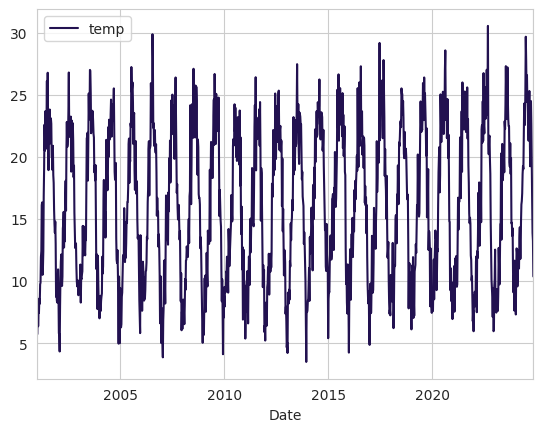

In [ ]:
weekly_df.plot(x='Date',y='temp')

### Wikipidia web page

The following wikipedia crawler was inspired by this article: https://dev.to/admantium/nlp-project-wikipedia-article-crawler-classification-corpus-reader-dik.It was modified for improved performances.

In [ ]:
class WikipediaReader():
    def __init__(self, dir = "articles"):
        self.pages = set()
        self.article_path = os.path.join("./", dir)
        self.wiki = wiki_api.Wikipedia(user_agent = "Dataproject Dauphine (kathleen.rogan@dauphine.eu)",

                language = 'en',
                extract_format=wiki_api.ExtractFormat.WIKI)
        try:
            os.mkdir(self.article_path)
        except Exception as e:
            pass

    def _get_page_title(self, article):
        return re.sub(r'\s+','_', article)

    def add_article(self, article):
        try:
            page = self.wiki.page(self._get_page_title(article))
            if page.exists():
                self.pages.add(page)
                return(page)
        except Exception as e:
            print(e)

    def list(self):
        return self.pages

    def process(self, update=False):
        for page in self.pages:
            filename = re.sub('\s+', '_', f'{page.title}')
            filename = re.sub(r'[\(\):]','', filename)
            file_path = os.path.join(self.article_path, f'{filename}.txt')
            if update or not os.path.exists(file_path):
                print(f'Downloading {page.title} ...')
                content = page.text
                with open(file_path, 'w') as file:
                    file.write(content)
            else:
                print(f'Not updating {page.title} ...')


    def crawl_pages(self, article, depth=2, total_number=50):

        if len(self.pages) >= total_number:
            return  # Stop crawling if we've reached the limit

        page = self.add_article(article)
        if not page:
            return

        # Root article text for similarity comparisons
        root_text = page.text if hasattr(page, "text") else ""
        root_categories = set(page.categories.keys()) if hasattr(page, "categories") else set()

        # Collect child links with relevance scores
        child_relevance = []
        for child in page.links.keys():
            if len(self.pages) >= total_number:  # Check limit inside the loop
                break

            child_page = self.add_article(child)
            if not child_page or child_page in self.pages:
                continue

            # Compute relevance: category overlap + text similarity
            child_categories = set(child_page.categories.keys()) if hasattr(child_page, "categories") else set()
            category_overlap = len(root_categories.intersection(child_categories))

            # Compute text similarity (TF-IDF)
            child_text = child_page.text if hasattr(child_page, "text") else ""
            tfidf_vectorizer = TfidfVectorizer(stop_words="english")
            vectors = tfidf_vectorizer.fit_transform([root_text, child_text])
            text_similarity = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]

            # Combine scores (weights can be adjusted)
            relevance_score = category_overlap * 2 + text_similarity
            child_relevance.append((child, relevance_score))

        # Sort children by relevance (descending)
        sorted_children = sorted(child_relevance, key=lambda x: x[1], reverse=True)

        # Add the most relevant child articles
        for child, _ in sorted_children:
            if len(self.pages) >= total_number:  # Stop adding if limit is reached
                break
            print(f'Adding article {len(self.pages)}/{total_number}: {child}')
            self.add_article(child)

        # Recurse if depth > 0
        depth -= 1
        if depth > 0:
            for child, _ in sorted_children:
                if len(self.pages) >= total_number:  # Stop recursing if limit is reached
                    break
                self.crawl_pages(child, depth, total_number)

    def get_categories(self, title):
        page = self.add_article(title)
        if page:
            if (list(page.categories.keys())) and (len(list(page.categories.keys())) > 0):
                categories = [c.replace('Category:','').lower() for c in list(page.categories.keys())
                   if c.lower().find('articles') == -1
                   and c.lower().find('pages') == -1
                   and c.lower().find('wikipedia') == -1
                   and c.lower().find('cs1') == -1
                   and c.lower().find('webarchive') == -1
                   and c.lower().find('dmy dates') == -1
                   and c.lower().find('short description') == -1
                   and c.lower().find('commons category') == -1

                ]
                return dict.fromkeys(categories, 1)
        return {}



In [ ]:
reader = WikipediaReader()
reader.crawl_pages("Influenza")

pages_list = reader.list()

df = pd.DataFrame(pages_list)

In [ ]:
df

,0
0,"Arthur Albert St. Mouritz (lang: en, variant: ..."
1,Acute exacerbation of chronic obstructive pulm...
2,"2006 H5N1 outbreak in India (lang: en, variant..."
3,"Antigenic shift (lang: en, variant: None, id: ..."
4,"Antiviral drug (lang: en, variant: None, id: 4..."
5,"1557 influenza pandemic (lang: en, variant: No..."
6,"2020–2025 H5N1 outbreak (lang: en, variant: No..."
7,"Adult T-cell leukemia/lymphoma (lang: en, vari..."
8,"1580 influenza pandemic (lang: en, variant: No..."
9,"2017–2018 United States flu season (lang: en, ..."


In [ ]:

# Base URL for the GitHub repository
base_url = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Wikipedia/pageviews-20150701-20241117_"

# Generate file URLs for flu data files from flu_1.csv to flu_10.csv
datafile = [f'{base_url}{i}.csv' for i in range(1, 6)]

for i, file in enumerate(datafile):
    # Read the CSV file with the correct separator and skip the first row
    df0 = pd.read_csv(file, sep=",")

    # Extract the date column
    dates = df0.iloc[:, 0]

    data = df0.iloc[:, 1:]
    data = data


    # Combine dates and data into one DataFrame and rename columns
    results = pd.concat([dates, data], axis=1)


    # Sort by 'Mois'
    results = results.sort_values(by='Date')

    # Merge with existing DataFrame or create a new one
    if i == 0:
        df = results.copy()
    else:
        df = pd.merge(df, results, on='Date')

# Final sorting by 'Mois'
wikipedia_2015 = df.sort_values(by="Date")

In [ ]:
wikipedia_2015

,Date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,1957–1958 influenza pandemic_x,Antigenic shift,...,Flu,Sinusitis,Fatigue,Feeling cold,Bronchitis,Pneumonia,Headache,Congestion,Chest pain,Soar throat
0,2015-07-01,2602,0,145,1887,391,132,1932,0,130,...,77,2015,121,1.0,2399,7326,1262,174,322,0.0
1,2015-07-02,2405,0,145,1895,405,127,1443,0,126,...,74,2022,139,0.0,2294,7331,1260,190,318,0.0
2,2015-07-03,2127,0,197,1456,365,133,1280,0,92,...,68,1710,103,4.0,2205,6961,1139,158,311,0.0
3,2015-07-04,1882,0,145,1155,298,119,1146,0,85,...,71,1531,97,0.0,1799,6141,1069,134,266,0.0
4,2015-07-05,2551,0,144,1291,369,118,1263,0,83,...,75,1775,101,0.0,1998,6780,1279,149,321,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,2024-11-13,1698,201,202,788,1136,112,605,94,60,...,31,1948,544,0.0,2218,6733,523,25,421,0.0
3424,2024-11-14,1497,196,290,904,1087,141,597,95,47,...,33,1431,517,0.0,2222,6622,539,37,448,0.0
3425,2024-11-15,1357,214,273,760,1087,129,604,101,28,...,20,1373,482,0.0,2133,6131,540,31,411,0.0
3426,2024-11-16,1109,229,182,630,903,87,601,86,32,...,15,1255,463,NaN,1779,5717,474,24,451,NaN


In [ ]:
url7 = "https://raw.githubusercontent.com/Tiny-boot/Data_project/main/Wikipedia/pageviews_data.csv"
wikipedia_2008 = pd.read_csv(url7)

In [ ]:
wikipedia_2008

,date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,...,Flu,Sinusitis,Fatigue,Feeling cold,Bronchitis,Pneumonia,Headache,Congestion,Chest pain,Soar throat
0,2007-12-10,4153,0,21,2686,1982,83,101,197,4305,...,828,1830,519,0,3624,6774,1882,220,845,0
1,2007-12-11,4606,0,39,2631,2114,91,95,191,4173,...,900,1873,497,0,3697,6732,1874,216,773,0
2,2007-12-12,4396,0,24,2649,2000,101,75,229,3943,...,785,1770,455,0,3590,6771,1646,224,739,0
3,2007-12-13,3863,0,46,2587,1933,117,68,182,3667,...,689,1666,420,0,3414,6589,1698,206,737,0
4,2007-12-14,3365,0,28,1917,1669,86,85,144,3191,...,648,1502,350,0,2862,5619,1477,187,638,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6197,2024-11-27,1613,230,275,1136,1053,187,657,75,2701,...,32,1446,744,0,2158,6171,571,38,601,0
6198,2024-11-28,1498,236,205,1009,1149,181,604,64,2543,...,43,1366,699,0,1968,5933,555,34,512,0
6199,2024-11-29,1523,149,263,718,1084,138,636,53,2323,...,37,1350,640,7,1916,5703,633,42,448,0
6200,2024-11-30,1291,230,364,722,1109,106,609,32,2273,...,40,1342,527,0,1868,5549,511,20,495,0


In [ ]:
wikipedia_2008.rename(columns={'date': 'Date'}, inplace=True)

In [ ]:
articles = wikipedia_2008.columns[0:].tolist()


In [ ]:
articles

['Date',
 'Influenza',
 '1889–1890 pandemic',
 'Viral encephalitis',
 'Antibody',
 'Acute bronchitis',
 'Adamantane',
 'Allergic rhinitis',
 'Antigenic shift',
 'Aspirin',
 'Paracetamol',
 'Spanish flu',
 'Antigen',
 'Arrhythmia',
 'Antiviral drug',
 'Antigenic drift',
 'Adenovirus infection',
 'Amantadine',
 'Aspiration pneumonia',
 'Antigenic variation',
 'Aluminosis',
 'Adenoid hypertrophy',
 'Adenoviridae',
 'Flu',
 'Sinusitis',
 'Fatigue',
 'Feeling cold',
 'Bronchitis',
 'Pneumonia',
 'Headache',
 'Congestion',
 'Chest pain',
 'Soar throat']

In [ ]:
wikipedia_2015 = wikipedia_2015[wikipedia_2015.columns.intersection(articles)]


In [ ]:
wikipedia_2015

,Date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,...,Flu,Sinusitis,Fatigue,Feeling cold,Bronchitis,Pneumonia,Headache,Congestion,Chest pain,Soar throat
0,2015-07-01,2602,0,145,1887,391,132,1932,130,3657,...,77,2015,121,1.0,2399,7326,1262,174,322,0.0
1,2015-07-02,2405,0,145,1895,405,127,1443,126,3460,...,74,2022,139,0.0,2294,7331,1260,190,318,0.0
2,2015-07-03,2127,0,197,1456,365,133,1280,92,3126,...,68,1710,103,4.0,2205,6961,1139,158,311,0.0
3,2015-07-04,1882,0,145,1155,298,119,1146,85,2709,...,71,1531,97,0.0,1799,6141,1069,134,266,0.0
4,2015-07-05,2551,0,144,1291,369,118,1263,83,3078,...,75,1775,101,0.0,1998,6780,1279,149,321,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,2024-11-13,1698,201,202,788,1136,112,605,60,2505,...,31,1948,544,0.0,2218,6733,523,25,421,0.0
3424,2024-11-14,1497,196,290,904,1087,141,597,47,2510,...,33,1431,517,0.0,2222,6622,539,37,448,0.0
3425,2024-11-15,1357,214,273,760,1087,129,604,28,2386,...,20,1373,482,0.0,2133,6131,540,31,411,0.0
3426,2024-11-16,1109,229,182,630,903,87,601,32,2155,...,15,1255,463,NaN,1779,5717,474,24,451,NaN


In [ ]:

# Define a function to clean and standardize the DataFrame
def clean_dataframe(df, year_suffix):

    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

    df = df.rename(columns={col: f"{col.split('_')[0]}_{year_suffix}" for col in df.columns if col != 'Date'})

    return df

# Clean and prepare the DataFrames
wiki_2008_cleaned = clean_dataframe(wikipedia_2008, '2008')
wiki_2015_cleaned = clean_dataframe(wikipedia_2015, '2015')

# Merge the two DataFrames on the 'Date' column
merged_df = pd.merge(wiki_2008_cleaned, wiki_2015_cleaned, on='Date', how='outer')

# Create a final DataFrame to store combined results
final_columns = ['Date'] + [col.split('_')[0] for col in merged_df.columns if col != 'Date' and col.endswith('_2008')]
wikipedia = pd.DataFrame(columns=final_columns)

# Fill the 'Date' column in the final DataFrame
wikipedia['Date'] = merged_df['Date']

# Process each metric column
for metric in final_columns[1:]:  # Skip 'Date'
    # Get columns for this metric from 2008 and 2015
    col_2008 = f"{metric}_2008"
    col_2015 = f"{metric}_2015"

    # Compute the mean for overlapping dates and combine values
    wikipedia[metric] = merged_df[[col_2008, col_2015]].mean(axis=1)




In [ ]:
wikipedia

,Date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,...,Flu,Sinusitis,Fatigue,Feeling cold,Bronchitis,Pneumonia,Headache,Congestion,Chest pain,Soar throat
0,2007-12-10,4153.0,0.0,21.0,2686.0,1982.0,83.0,101.0,197.0,4305.0,...,828.0,1830.0,519.0,0.0,3624.0,6774.0,1882.0,220.0,845.0,0.0
1,2007-12-11,4606.0,0.0,39.0,2631.0,2114.0,91.0,95.0,191.0,4173.0,...,900.0,1873.0,497.0,0.0,3697.0,6732.0,1874.0,216.0,773.0,0.0
2,2007-12-12,4396.0,0.0,24.0,2649.0,2000.0,101.0,75.0,229.0,3943.0,...,785.0,1770.0,455.0,0.0,3590.0,6771.0,1646.0,224.0,739.0,0.0
3,2007-12-13,3863.0,0.0,46.0,2587.0,1933.0,117.0,68.0,182.0,3667.0,...,689.0,1666.0,420.0,0.0,3414.0,6589.0,1698.0,206.0,737.0,0.0
4,2007-12-14,3365.0,0.0,28.0,1917.0,1669.0,86.0,85.0,144.0,3191.0,...,648.0,1502.0,350.0,0.0,2862.0,5619.0,1477.0,187.0,638.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6197,2024-11-27,1613.0,230.0,275.0,1136.0,1053.0,187.0,657.0,75.0,2701.0,...,32.0,1446.0,744.0,0.0,2158.0,6171.0,571.0,38.0,601.0,0.0
6198,2024-11-28,1498.0,236.0,205.0,1009.0,1149.0,181.0,604.0,64.0,2543.0,...,43.0,1366.0,699.0,0.0,1968.0,5933.0,555.0,34.0,512.0,0.0
6199,2024-11-29,1523.0,149.0,263.0,718.0,1084.0,138.0,636.0,53.0,2323.0,...,37.0,1350.0,640.0,7.0,1916.0,5703.0,633.0,42.0,448.0,0.0
6200,2024-11-30,1291.0,230.0,364.0,722.0,1109.0,106.0,609.0,32.0,2273.0,...,40.0,1342.0,527.0,0.0,1868.0,5549.0,511.0,20.0,495.0,0.0


In [ ]:
wikipedia["Date"]= wikipedia["Date"].astype('datetime64[ns]')
weekly_wikipedia = wikipedia.resample('W-Sat', label='right', closed = 'right', on='Date').mean().round(0).reset_index().sort_values(by='Date')

In [ ]:
weekly_wikipedia

,Date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,...,Flu,Sinusitis,Fatigue,Feeling cold,Bronchitis,Pneumonia,Headache,Congestion,Chest pain,Soar throat
0,2007-12-15,3755.0,0.0,30.0,2257.0,1825.0,86.0,78.0,178.0,3547.0,...,718.0,1618.0,415.0,0.0,3199.0,6077.0,1630.0,198.0,705.0,0.0
1,2007-12-22,3016.0,0.0,22.0,1425.0,1678.0,65.0,67.0,76.0,2576.0,...,690.0,1478.0,314.0,0.0,2898.0,5205.0,1391.0,130.0,597.0,0.0
2,2007-12-29,1816.0,0.0,17.0,657.0,1453.0,54.0,50.0,33.0,1775.0,...,592.0,1237.0,259.0,0.0,2363.0,3937.0,1213.0,98.0,503.0,0.0
3,2008-01-05,2473.0,0.0,16.0,987.0,2109.0,53.0,63.0,46.0,2483.0,...,746.0,1723.0,430.0,0.0,3265.0,5429.0,1598.0,128.0,679.0,0.0
4,2008-01-12,3334.0,0.0,29.0,1691.0,2432.0,70.0,79.0,99.0,3562.0,...,866.0,2155.0,517.0,0.0,3935.0,7756.0,1801.0,175.0,811.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2024-11-09,1384.0,214.0,206.0,867.0,1069.0,139.0,641.0,56.0,2598.0,...,34.0,1471.0,596.0,0.0,2035.0,5957.0,567.0,36.0,493.0,0.0
883,2024-11-16,1528.0,242.0,240.0,905.0,1106.0,153.0,661.0,59.0,2544.0,...,35.0,1535.0,609.0,1.0,2146.0,6504.0,613.0,36.0,483.0,0.0
884,2024-11-23,1721.0,241.0,227.0,1034.0,1184.0,147.0,687.0,70.0,2614.0,...,51.0,1477.0,647.0,0.0,2102.0,6709.0,620.0,41.0,591.0,0.0
885,2024-11-30,1545.0,215.0,257.0,922.0,1159.0,146.0,654.0,63.0,2541.0,...,39.0,1414.0,1321.0,1.0,2049.0,6168.0,583.0,33.0,533.0,0.0


<Axes: xlabel='Date'>

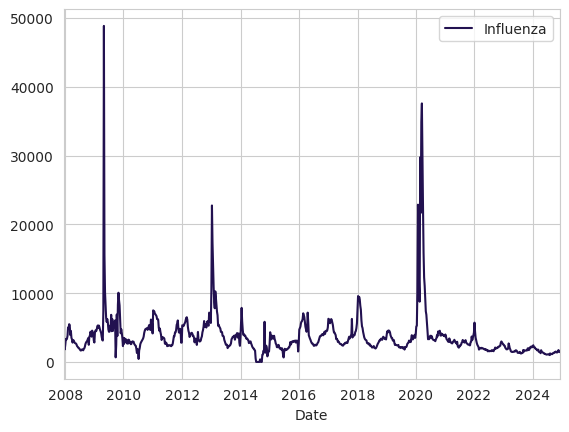

In [ ]:
weekly_wikipedia.plot(x='Date',y='Influenza')

### Google trend

In [ ]:
pd.set_option('future.no_silent_downcasting', True)
# Define a function to clean a single file
def clean_file(file_path):

    # Read the file while skipping the first row
    df = pd.read_csv(file_path, header=1)

    # Standardize column names
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    df.replace({r'<\s*1': 0}, inplace=True, regex=True)
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

    # Convert the first column (assumed to be the date column) to datetime
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce')

    return df

# Define a function to merge multiple DataFrames
def merge_dataframes(file_paths):
    # Initialize a list to store cleaned DataFrames
    cleaned_dataframes = [clean_file(file_path) for file_path in file_paths]

    # Merge all datasets on 'Semaine'
    merged_df = cleaned_dataframes[0]
    for df in cleaned_dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on='Semaine', how='outer', suffixes=('', '_drop'))
        for col in merged_df.columns:
            if col.endswith('_drop'):
                merged_df[col.replace('_drop', '')] = merged_df[[col.replace('_drop', ''), col]].mean(axis=1)
                merged_df.drop(columns=[col], inplace=True)



    return merged_df

merged_dfs = {}  # Dictionary to store merged DataFrames

for i in range(1,11):
    file_paths_groupi = [
        f'https://raw.githubusercontent.com/Tiny-boot/Data_project/main/rw/rw2list{i}.csv',
        f'https://raw.githubusercontent.com/Tiny-boot/Data_project/main/rw/rw1list{i}.csv',
        f'https://raw.githubusercontent.com/Tiny-boot/Data_project/main/rw/rwlist{i}.csv',
        f'https://raw.githubusercontent.com/jinane1amal/Dataproject/main/rw/rwalist{i}.csv',
        f'https://raw.githubusercontent.com/jinane1amal/Dataproject/main/rw/rwblist{i}.csv',
        f'https://raw.githubusercontent.com/jinane1amal/Dataproject/main/rw/rwclist{i}.csv',
        f'https://raw.githubusercontent.com/jinane1amal/Dataproject/main/rw/rwdlist{i}.csv',
        f'https://raw.githubusercontent.com/jinane1amal/Dataproject/main/rw/rwelist{i}.csv'
    ]



    # Store the merged DataFrame for the current group in the dictionary
    merged_dfs[f'merged_df{i}'] = merge_dataframes(file_paths_groupi)






In [ ]:


# Generate file URLs for flu data files from flu_1.csv to flu_10.csv
dataframes = [merged_dfs.get(f'merged_df{i}') for i in range(1, 11)]

# Initialize the final DataFrame
df = None

for i, df0 in enumerate(dataframes):
    if df0 is not None:  # Ensure DataFrame exists
        # Drop the 'flu' column for all DataFrames except the first
        if i > 0 and 'flu' in df0.columns:
            df0 = df0.drop("flu", axis=1)

        # Extract the date column
        dates = df0.iloc[:, 0]

        # Extract the data columns
        data = df0.iloc[:, 1:]

        # Combine dates and data into one DataFrame
        results = pd.concat([dates, data], axis=1)

        # Sort by 'Date'
        results = results.sort_values(by='Semaine')

        # Merge with the main DataFrame
        if df is None:
            df = results.copy()
        else:
            df = pd.merge(df, results, on='Semaine', how='outer')

# Final sorting by 'Date'
google = df.sort_values(by="Semaine")

# Save the final DataFrame to a CSV file
google.to_csv('df_proba.csv', index=False)


In [ ]:
google

,Semaine,flu,shaking shills,myalgia,irratibility,diarrhea,irritability,sinusitis,stomach flu,fatigue,...,fainting,pass out,bronchitis,pneumonia,flu symptoms,headache,fever,migraine,congestion,sickness
0,2007-12-30 00:00:00,2.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
1,2008-01-06 00:00:00,2.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
2,2008-01-13 00:00:00,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
3,2008-01-20 00:00:00,2.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
4,2008-01-27 00:00:00,2.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,2024-10-27 00:00:00,13.0,0.0,0.0,0.0,9.0,NaN,1.0,1.0,3.0,...,1.0,1.0,2.0,8.0,1.0,8.0,13.0,3.0,2.0,3.0
879,2024-11-03 00:00:00,11.0,0.0,0.0,0.0,8.0,NaN,1.0,1.0,3.0,...,0.0,1.0,2.0,7.0,1.0,7.0,11.0,3.0,3.0,3.0
880,2024-11-10 00:00:00,16.0,0.0,0.0,0.0,11.0,NaN,1.0,2.0,3.0,...,1.0,1.0,3.0,8.0,2.0,8.0,14.0,3.0,3.0,4.0
881,2024-11-17 00:00:00,16.0,0.0,0.0,0.0,11.0,NaN,1.0,2.0,3.0,...,1.0,1.0,3.0,8.0,2.0,9.0,14.0,4.0,3.0,4.0


In [ ]:
columns_with_nan = google.isnull().sum()
columns_with_nan = columns_with_nan[columns_with_nan > 0]  # Filter non-zero counts

print("Columns with missing values:")
print(columns_with_nan)

Columns with missing values:
irratibility               264
irritability               617
sinusitis                   55
sinusitus                  826
social distancing          208
conjonctivis distancing    673
dtype: int64


In [ ]:
google = google.drop(columns = ['irratibility','irritability','sinusitis','sinusitus','social distancing','conjonctivis distancing'])

In [ ]:
google.rename(columns={'Semaine': 'Date'}, inplace=True)


In [ ]:
google['Date'] = google['Date'] - pd.Timedelta(days=1)


In [ ]:
keywords = google.columns[1:].tolist()

In [ ]:
keywords

['flu',
 'shaking shills',
 'myalgia',
 'diarrhea',
 'stomach flu',
 'fatigue',
 'feeling cold',
 'difficulty breathing',
 'sneezing',
 'dry cough',
 'difficulty sleeping',
 'vomiting',
 'abdominal pain',
 'influenza',
 'sore throat',
 'dyspnea',
 'rhinorrhea',
 'throwing up',
 'polypnea',
 'conjonctivis',
 'cyanosis',
 'h1n1',
 'hygiene',
 'drug use',
 'runny nose',
 'chest pain',
 'arthralgia',
 'fainting',
 'pass out',
 'bronchitis',
 'pneumonia',
 'flu symptoms',
 'headache',
 'fever',
 'migraine',
 'congestion',
 'sickness']

In [ ]:
google = google[google.index.isin(merged.index)]

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



<Axes: xlabel='Date'>

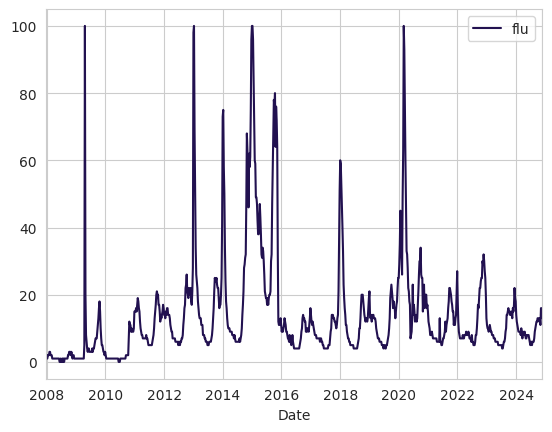

In [ ]:
google.plot(x='Date',y='flu')

https://pypi.org/project/gtrends/

##**Preprocessing**

In [ ]:
weekly_wikipedia['Date'] = pd.to_datetime(weekly_wikipedia['Date'], errors='coerce')
google['Date'] = pd.to_datetime(google['Date'], errors='coerce')

In [ ]:
merge= pd.merge(weekly_wikipedia,google, how='right')

In [ ]:
merge

,Date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,...,fainting,pass out,bronchitis,pneumonia,flu symptoms,headache,fever,migraine,congestion,sickness
0,2007-12-29,1816.0,0.0,17.0,657.0,1453.0,54.0,50.0,33.0,1775.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
1,2008-01-05,2473.0,0.0,16.0,987.0,2109.0,53.0,63.0,46.0,2483.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
2,2008-01-12,3334.0,0.0,29.0,1691.0,2432.0,70.0,79.0,99.0,3562.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
3,2008-01-19,3249.0,0.0,26.0,1928.0,2180.0,85.0,90.0,82.0,3826.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
4,2008-01-26,3355.0,0.0,30.0,1938.0,2347.0,87.0,84.0,62.0,3952.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,2024-10-26,1467.0,226.0,237.0,965.0,972.0,170.0,714.0,48.0,2540.0,...,1.0,1.0,2.0,8.0,1.0,8.0,13.0,3.0,2.0,3.0
879,2024-11-02,1372.0,214.0,232.0,843.0,1004.0,131.0,674.0,60.0,2517.0,...,0.0,1.0,2.0,7.0,1.0,7.0,11.0,3.0,3.0,3.0
880,2024-11-09,1384.0,214.0,206.0,867.0,1069.0,139.0,641.0,56.0,2598.0,...,1.0,1.0,3.0,8.0,2.0,8.0,14.0,3.0,3.0,4.0
881,2024-11-16,1528.0,242.0,240.0,905.0,1106.0,153.0,661.0,59.0,2544.0,...,1.0,1.0,3.0,8.0,2.0,9.0,14.0,4.0,3.0,4.0


In [ ]:
X = pd.merge(merge, weekly_df, on='Date', how='left')

In [ ]:
X

,Date,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,...,migraine,congestion,sickness,tempmax,tempmin,temp,dew,humidity,precip,windspeed
0,2007-12-29,1816.0,0.0,17.0,657.0,1453.0,54.0,50.0,33.0,1775.0,...,0.0,0.0,1.0,10.23,2.61,6.14,0.46,70.07,0.62,23.29
1,2008-01-05,2473.0,0.0,16.0,987.0,2109.0,53.0,63.0,46.0,2483.0,...,0.0,0.0,1.0,11.61,3.46,6.97,3.49,79.99,8.72,26.84
2,2008-01-12,3334.0,0.0,29.0,1691.0,2432.0,70.0,79.0,99.0,3562.0,...,0.0,0.0,1.0,10.76,6.87,8.51,6.16,85.61,1.54,16.87
3,2008-01-19,3249.0,0.0,26.0,1928.0,2180.0,85.0,90.0,82.0,3826.0,...,0.0,0.0,1.0,12.86,1.87,6.60,1.94,75.83,0.02,17.46
4,2008-01-26,3355.0,0.0,30.0,1938.0,2347.0,87.0,84.0,62.0,3952.0,...,0.0,0.0,1.0,10.11,5.06,7.47,4.49,82.86,9.87,21.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,2024-10-26,1467.0,226.0,237.0,965.0,972.0,170.0,714.0,48.0,2540.0,...,3.0,2.0,3.0,25.57,9.14,16.57,4.84,50.36,0.01,12.56
879,2024-11-02,1372.0,214.0,232.0,843.0,1004.0,131.0,674.0,60.0,2517.0,...,3.0,3.0,3.0,19.91,8.67,13.87,7.43,68.21,1.89,18.09
880,2024-11-09,1384.0,214.0,206.0,867.0,1069.0,139.0,641.0,56.0,2598.0,...,3.0,3.0,4.0,21.26,6.86,13.23,2.13,52.16,0.00,22.27
881,2024-11-16,1528.0,242.0,240.0,905.0,1106.0,153.0,661.0,59.0,2544.0,...,4.0,3.0,4.0,16.57,5.10,10.37,5.98,76.85,0.99,14.27


In [ ]:
X = X[(X['Date'] >= '2008-01-01') & (X['Date'] <= '2020-01-01')]


In [ ]:
X.dtypes

,0
Date,datetime64[ns]
Influenza,float64
1889–1890 pandemic,float64
Viral encephalitis,float64
Antibody,float64
...,...
temp,float64
dew,float64
humidity,float64
precip,float64


In [ ]:
X = X.set_index("Date")
merged=merged.set_index("Date")
y = merged["ILI"]


In [ ]:

X, y = X.align(y, join='inner', axis=0)


In [ ]:
X

,Influenza,1889–1890 pandemic,Viral encephalitis,Antibody,Acute bronchitis,Adamantane,Allergic rhinitis,Antigenic shift,Aspirin,Paracetamol,...,migraine,congestion,sickness,tempmax,tempmin,temp,dew,humidity,precip,windspeed
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-05,2473.0,0.0,16.0,987.0,2109.0,53.0,63.0,46.0,2483.0,3418.0,...,0.0,0.0,1.0,11.61,3.46,6.97,3.49,79.99,8.72,26.84
2008-01-12,3334.0,0.0,29.0,1691.0,2432.0,70.0,79.0,99.0,3562.0,3528.0,...,0.0,0.0,1.0,10.76,6.87,8.51,6.16,85.61,1.54,16.87
2008-01-19,3249.0,0.0,26.0,1928.0,2180.0,85.0,90.0,82.0,3826.0,3278.0,...,0.0,0.0,1.0,12.86,1.87,6.60,1.94,75.83,0.02,17.46
2008-01-26,3355.0,0.0,30.0,1938.0,2347.0,87.0,84.0,62.0,3952.0,2838.0,...,0.0,0.0,1.0,10.11,5.06,7.47,4.49,82.86,9.87,21.43
2008-02-02,3777.0,0.0,30.0,1849.0,2546.0,86.0,75.0,78.0,3669.0,2584.0,...,0.0,0.0,1.0,9.86,2.96,6.53,3.36,81.61,3.70,26.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,3286.0,0.0,89.0,1713.0,634.0,197.0,1075.0,148.0,3344.0,5075.0,...,3.0,2.0,3.0,12.99,3.51,7.97,1.70,68.43,2.03,25.10
2019-12-07,3620.0,0.0,91.0,1935.0,634.0,154.0,1104.0,157.0,3390.0,5122.0,...,3.0,2.0,3.0,15.63,10.20,12.63,10.36,86.97,10.49,20.89
2019-12-14,3583.0,0.0,80.0,1827.0,602.0,171.0,1043.0,189.0,3169.0,5194.0,...,3.0,2.0,3.0,15.03,9.16,11.87,9.71,87.23,1.63,13.00


In [ ]:
y

,ILI
Date,
2008-01-05,450.0
2008-01-12,651.0
2008-01-19,755.0
2008-01-26,938.0
2008-02-02,1024.0
...,...
2019-11-30,1177.0
2019-12-07,1683.0
2019-12-14,1640.0


In [ ]:
data = pd.merge(X,y, on ="Date", how="left")
features = X.columns.to_list()

target = 'ILI'

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features + [target]])
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

X_scaled = data_scaled[features].values
y_scaled = data_scaled[target].values

train_ratio = 0.6
test_ratio = 0.40

# Compute split indices
train_end = int(len(X_scaled) * train_ratio)
test_end = train_end + int(len(X_scaled) * test_ratio)

# Create splits
X_train, X_test = X_scaled[:train_end], X_scaled[train_end:test_end]
y_train,  y_test = y_scaled[:train_end], y_scaled[train_end:test_end]

# Print sizes of splits
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")



Train size: 375, Test size: 250


In [ ]:
past = 4

# Prepare data for ARX

def create_lagged_features_split(X, y, past):
    X_lagged, y_lagged = [], []
    for i in range(past, len(X)):
        # Collect past values and flatten them
        X_lagged.append(np.array(X[i-past:i].flatten(), dtype=np.float32))
        # Use the corresponding target value
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged, dtype=np.float32)



# Apply to training set
X_train_lagged, y_train_lagged = create_lagged_features_split(X_train, y_train, past)


# Apply to test set
X_test_lagged, y_test_lagged = create_lagged_features_split(X_test, y_test, past)



In [ ]:

# Define the function to convert the dataset to a supervised format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Combine the features with the target for each dataset (train, validation, test)
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)

test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test)], axis=1)


n_in, n_out = 4, 4

train_supervised = series_to_supervised(train_data.values, n_in, n_out)

test_supervised = series_to_supervised(test_data.values, n_in, n_out)

# Split into input and outputs for each set
n_features = X_train.shape[1]

# Train data
train_X, train_y = train_supervised.iloc[:, :n_in * n_features], train_supervised.iloc[:, -1]

# Test data
test_X, test_y = test_supervised.iloc[:, :n_in * n_features], test_supervised.iloc[:, -1]

# Reshape inputs to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], n_in, n_features))

test_X = test_X.values.reshape((test_X.shape[0], n_in, n_features))



### Variable selection
####1.Filter method using Pearson correlation

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/


In [ ]:

n_features = 30

selector = SelectKBest(f_regression, k=n_features)
X_filter = selector.fit_transform(X, y)

mask = selector.get_support()

X_train_f, X_test_f = X[:train_end], X[train_end:test_end]
y_train_f, y_test_f = y[:train_end], y[train_end:test_end]

X_train_corr = X_train_f.loc[:,mask]
X_test_corr = X_test_f.loc[:,mask]
new_features = X_train_f.loc[:,mask].columns.tolist()

print("Selected features:", new_features)

X_train_corr.head()

Selected features: ['Influenza', 'Viral encephalitis', 'Adamantane', 'Allergic rhinitis', 'Paracetamol', 'Arrhythmia', 'Antiviral drug', 'Adenovirus infection', 'Aspiration pneumonia', 'Antigenic variation', 'Aluminosis', 'Adenoid hypertrophy', 'Adenoviridae', 'Bronchitis', 'Pneumonia', 'Soar throat', 'flu', 'stomach flu', 'dry cough', 'influenza', 'bronchitis', 'pneumonia', 'flu symptoms', 'congestion', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip']


,Influenza,Viral encephalitis,Adamantane,Allergic rhinitis,Paracetamol,Arrhythmia,Antiviral drug,Adenovirus infection,Aspiration pneumonia,Antigenic variation,...,bronchitis,pneumonia,flu symptoms,congestion,tempmax,tempmin,temp,dew,humidity,precip
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-05,2473.0,16.0,53.0,63.0,3418.0,392.0,279.0,98.0,134.0,7.0,...,0.0,1.0,0.0,0.0,11.61,3.46,6.97,3.49,79.99,8.72
2008-01-12,3334.0,29.0,70.0,79.0,3528.0,411.0,405.0,149.0,191.0,11.0,...,0.0,1.0,0.0,0.0,10.76,6.87,8.51,6.16,85.61,1.54
2008-01-19,3249.0,26.0,85.0,90.0,3278.0,417.0,383.0,136.0,195.0,11.0,...,1.0,1.0,0.0,0.0,12.86,1.87,6.60,1.94,75.83,0.02
2008-01-26,3355.0,30.0,87.0,84.0,2838.0,433.0,408.0,127.0,194.0,14.0,...,1.0,1.0,0.0,0.0,10.11,5.06,7.47,4.49,82.86,9.87
2008-02-02,3777.0,30.0,86.0,75.0,2584.0,358.0,391.0,129.0,198.0,17.0,...,1.0,1.0,0.0,0.0,9.86,2.96,6.53,3.36,81.61,3.70


In [ ]:
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train_f.columns, scores)}

# Create a dataframe and sort
feature_importances = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=True)

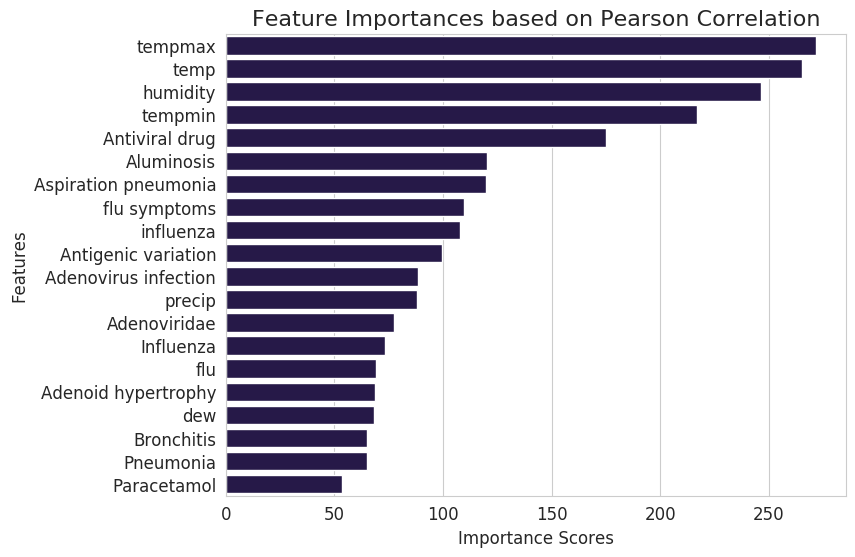

In [ ]:

def plot_importances(df_in, title):
    """Make a horizontal bar chart of feature importances"""
    # Set plot style
    plt.style.use('_classic_test_patch')  # Change to a valid style

    # Create horizontal bar plot
    sns.set_style('whitegrid')
    sns.set_palette('magma')
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_in, orient='h')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Importance Scores', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()  # Ensure the most important features are at the top
    plt.show()

# Get the feature importances
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train_f.columns, scores)}

# Convert to DataFrame and sort
feature_importances = (
    pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=True)
)
filtered_importances = feature_importances[feature_importances['Importance'] > 50]

# Plot feature importances
plot_importances(filtered_importances, 'Feature Importances based on Pearson Correlation')



In [ ]:
features_p = filtered_importances["Feature"].to_list()

In [ ]:
features_p

['Paracetamol',
 'Pneumonia',
 'Bronchitis',
 'dew',
 'Adenoid hypertrophy',
 'flu',
 'Influenza',
 'Adenoviridae',
 'precip',
 'Adenovirus infection',
 'Antigenic variation',
 'influenza',
 'flu symptoms',
 'Aspiration pneumonia',
 'Aluminosis',
 'Antiviral drug',
 'tempmin',
 'humidity',
 'temp',
 'tempmax']

In [ ]:
data = pd.merge(X,y, on ="Date", how="left")
features = X.columns.to_list()

target = 'ILI'

scaler = StandardScaler()
data_scaled_1 = scaler.fit_transform(data[features_p + [target]])
data_scaled_1 = pd.DataFrame(data_scaled, columns=features_p + [target])

X_scaled_1 = data_scaled_1[features_p].values
y_scaled_1 = data_scaled_1[target].values

train_ratio = 0.60
test_ratio = 0.40

train_end = int(len(X_scaled_1) * train_ratio)
test_end = train_end + int(len(X_scaled_1) * test_ratio)

# Create splits
X_train_1, X_test_1 = X_scaled_1[:train_end], X_scaled_1[train_end:test_end]
y_train_1, y_test_1 = y_scaled_1[:train_end], y_scaled_1[train_end:test_end]


In [ ]:
past = 4

# Prepare data for ARX

def create_lagged_features_split(X, y, past):
    X_lagged, y_lagged = [], []
    for i in range(past, len(X)):
        # Collect past values and flatten them
        X_lagged.append(np.array(X[i-past:i].flatten(), dtype=np.float32))
        # Use the corresponding target value
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged, dtype=np.float32)



# Apply to training set
X_train_lagged_1, y_train_lagged_1 = create_lagged_features_split(X_train_1, y_train_1, past)



# Apply to test set
X_test_lagged_1, y_test_lagged_1 = create_lagged_features_split(X_test_1, y_test_1, past)

In [ ]:
#LSTM Model preparation for Pearson features
# Define the function to convert the dataset to a supervised format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Combine the features with the target for each dataset (train, validation, test)
train_data_1 = pd.concat([pd.DataFrame(X_train_1), pd.Series(y_train_1)], axis=1)

test_data_1 = pd.concat([pd.DataFrame(X_test_1), pd.Series(y_test_1)], axis=1)


n_in, n_out = 4, 4

train_supervised_1 = series_to_supervised(train_data_1.values, n_in, n_out)

test_supervised_1 = series_to_supervised(test_data_1.values, n_in, n_out)

# Split into input and outputs for each set
n_features = X_train_1.shape[1]

# Train data
train_X_1, train_y_1 = train_supervised_1.iloc[:, :n_in * n_features], train_supervised_1.iloc[:, -1]

# Test data
test_X_1, test_y_1 = test_supervised_1.iloc[:, :n_in * n_features], test_supervised_1.iloc[:, -1]

# Reshape inputs to be 3D [samples, timesteps, features]
train_X_1 = train_X_1.values.reshape((train_X_1.shape[0], n_in, n_features))

test_X_1 = test_X_1.values.reshape((test_X_1.shape[0], n_in, n_features))

### 2. Filter using Random Forest

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)

rf = RandomForestRegressor(random_state=42)
rf_grid = {'min_samples_split': [2, 5] + list(range(10, 250,30)),
           'max_depth': [2, 5, 10, 15, 20]}
rf_cv = GridSearchCV(
    rf, rf_grid, cv=tscv, n_jobs=-1, scoring='r2'
)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 40, 70, 100, 130, 160,
                                               190, 220]},
             scoring='r2')

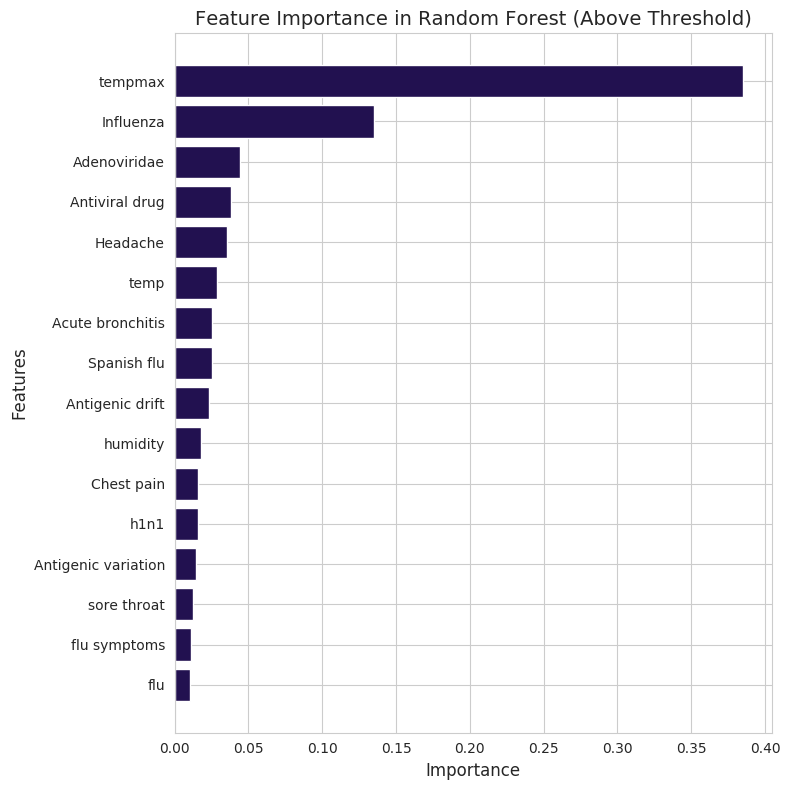

In [ ]:
# Extract the best model from GridSearchCV
best_rf_model = rf_cv.best_estimator_

# Get feature importances from the best Random Forest model
importance = best_rf_model.feature_importances_

# Define the threshold for feature importance
threshold = 0.01

# Identify features with importance above the threshold
important_features = [(feature, imp) for feature, imp in zip(X.columns, importance) if imp > threshold]

# Sort the features by importance in descending order
important_features.sort(key=lambda x: x[1], reverse=True)

# Unpack the feature names and their importance values
features_r, importance_values = zip(*important_features)

plt.figure(figsize=(8, len(features_r) * 0.5))  # Adjust height dynamically
plt.barh(features_r, importance_values)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title("Feature Importance in Random Forest (Above Threshold)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
features_r = list(features_r)

In [ ]:
data = pd.merge(X,y, on ="Date", how="left")
features = X.columns.to_list()

target = 'ILI'

scaler = StandardScaler()
data_scaled_2 = scaler.fit_transform(data[features_r + [target]])
data_scaled_2 = pd.DataFrame(data_scaled, columns=features_r + [target])

X_scaled_2 = data_scaled_2[features_r].values
y_scaled_2 = data_scaled_2[target].values

train_ratio = 0.60
test_ratio = 0.40

train_end = int(len(X_scaled_1) * train_ratio)
test_end = train_end + int(len(X_scaled_1) * test_ratio)

# Create splits
X_train_2, X_test_2 = X_scaled_2[:train_end], X_scaled_2[train_end:test_end]
y_train_2, y_test_2 = y_scaled_2[:train_end], y_scaled_2[train_end:test_end]

In [ ]:
past = 4

# Prepare data for ARX for Random Forest features

def create_lagged_features_split(X, y, past):
    X_lagged, y_lagged = [], []
    for i in range(past, len(X)):
        # Collect past values and flatten them
        X_lagged.append(np.array(X[i-past:i].flatten(), dtype=np.float32))
        # Use the corresponding target value
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged, dtype=np.float32)



# Apply to training set
X_train_lagged_2, y_train_lagged_2 = create_lagged_features_split(X_train_2, y_train_2, past)


# Apply to test set
X_test_lagged_2, y_test_lagged_2 = create_lagged_features_split(X_test_2, y_test_2, past)

In [ ]:
#LSTM Model preparation for Random Forest features
# Define the function to convert the dataset to a supervised format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Combine the features with the target for each dataset (train, validation, test)
train_data_2 = pd.concat([pd.DataFrame(X_train_2), pd.Series(y_train_2)], axis=1)
test_data_2 = pd.concat([pd.DataFrame(X_test_2), pd.Series(y_test_2)], axis=1)


n_in, n_out = 4, 4

train_supervised_2 = series_to_supervised(train_data_2.values, n_in, n_out)
test_supervised_2 = series_to_supervised(test_data_2.values, n_in, n_out)

# Split into input and outputs for each set
n_features = X_train_2.shape[1]

# Train data
train_X_2, train_y_2 = train_supervised_2.iloc[:, :n_in * n_features], train_supervised_2.iloc[:, -1]

# Test data
test_X_2, test_y_2 = test_supervised_2.iloc[:, :n_in * n_features], test_supervised_2.iloc[:, -1]

# Reshape inputs to be 3D [samples, timesteps, features]
train_X_2 = train_X_2.values.reshape((train_X_2.shape[0], n_in, n_features))
test_X_2 = test_X_2.values.reshape((test_X_2.shape[0], n_in, n_features))

##**Models**

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

### Linear Regression

*All features*

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
lr = LinearRegression()
lr_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

lr_cv = GridSearchCV(lr, lr_grid, cv=tscv, n_jobs=-1,
                     scoring='r2')
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2')

R² on the learning set: 0.7042078645417431


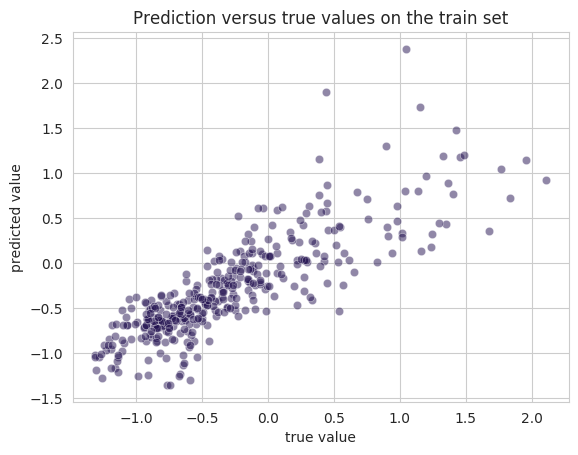

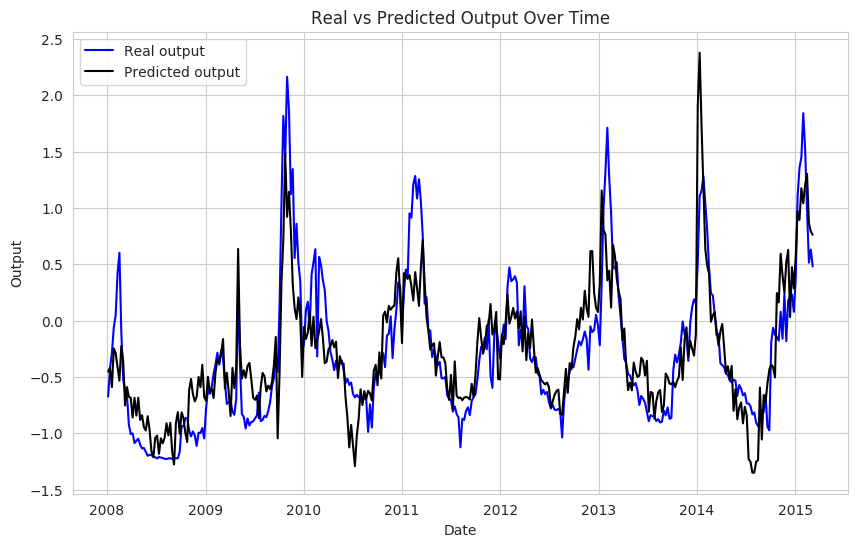

In [ ]:

print("R² on the learning set:", r2_score(y_train, lr_cv.predict(X_train)))
dates = np.array(data.index)[:len(X_train)]
pred_vs_true_train = pd.DataFrame({
    'true value': y_train,
    'predicted value': lr_cv.predict(X_train),
    'date': dates
})
pred_vs_true_train['true value'] += np.random.random_sample(len(y_train)) * 0.2 - 0.1

sns.scatterplot(data=pred_vs_true_train, x='true value', y='predicted value', alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dates, y_train, 'b', label='Real output')
plt.plot(dates, lr_cv.predict(X_train), 'black', label='Predicted output')
plt.xlabel('Date')
plt.ylabel('Output')
plt.legend()
plt.title("Real vs Predicted Output Over Time")
plt.savefig('prediction_online.png')
plt.show()

*Features based on Pearson correlation*

In [ ]:
lr_cv_1 = GridSearchCV(lr, lr_grid, cv=tscv, n_jobs=-1,
                     scoring='r2')
lr_cv_1.fit(X_train_1, y_train_1)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2')

R² on the learning set: 0.5535484638034982


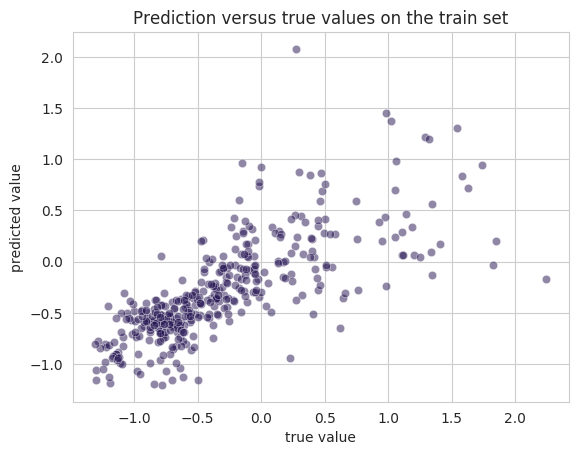

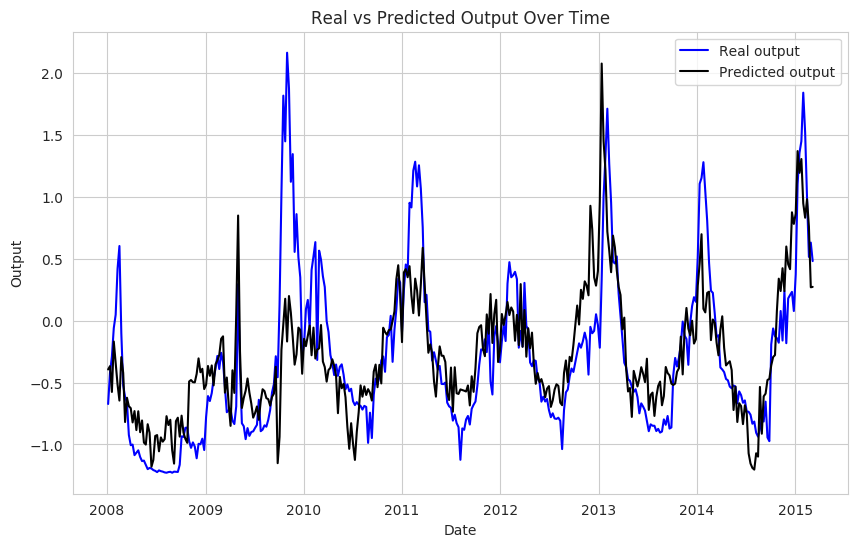

In [ ]:
print("R² on the learning set:", r2_score(y_train_1, lr_cv_1.predict(X_train_1)))#rmse of the optimal model on the train (y_train_predict)
dates = np.array(data.index)[:len(X_train)]
pred_vs_true_train = pd.DataFrame({
    'true value': y_train,
    'predicted value': lr_cv_1.predict(X_train_1),
    'date': dates
})
pred_vs_true_train['true value'] += np.random.random_sample(len(y_train_1)) * 0.2 - 0.1

sns.scatterplot(data=pred_vs_true_train, x='true value', y='predicted value', alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dates, y_train, 'b', label='Real output')
plt.plot(dates, lr_cv_1.predict(X_train_1), 'black', label='Predicted output')
plt.xlabel('Date')
plt.ylabel('Output')
plt.legend()
plt.title("Real vs Predicted Output Over Time")
plt.savefig('prediction_online.png')
plt.show()

*Feature based on Random Forest*

In [ ]:
lr_cv_2 = GridSearchCV(lr, lr_grid, cv=tscv, n_jobs=-1,
                     scoring='r2')
lr_cv_2.fit(X_train_2, y_train_2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2')

In [ ]:
print("R² on the learning set:", r2_score(y_train_2, lr_cv_2.predict(X_train_2)))

R² on the learning set: 0.5374792178843406


### Random Forest

*All features*

In [ ]:

tscv = TimeSeriesSplit(n_splits=10)

rf = RandomForestRegressor(random_state=42)
rf_grid = {'min_samples_split': [2, 5] + list(range(10, 250,5)),
           'max_depth': [2, 5, 10, 15, 20]}
rf_cv = GridSearchCV(
    rf, rf_grid, cv=tscv, n_jobs=-1, scoring='r2'
)
rf_cv.fit(X_train, y_train)




GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50, 55, 60, 65, 70, 75, 80,
                                               85, 90, 95, 100, 105, 110, 115,
                                               120, 125, 130, 135, 140, 145, ...]},
             scoring='r2')

R² on the learning set: 0.6302377035124123


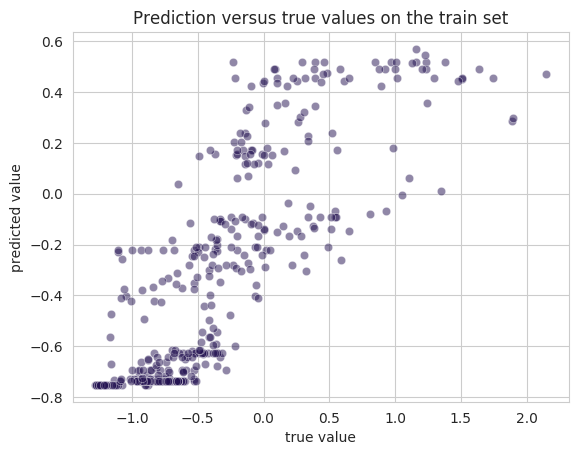

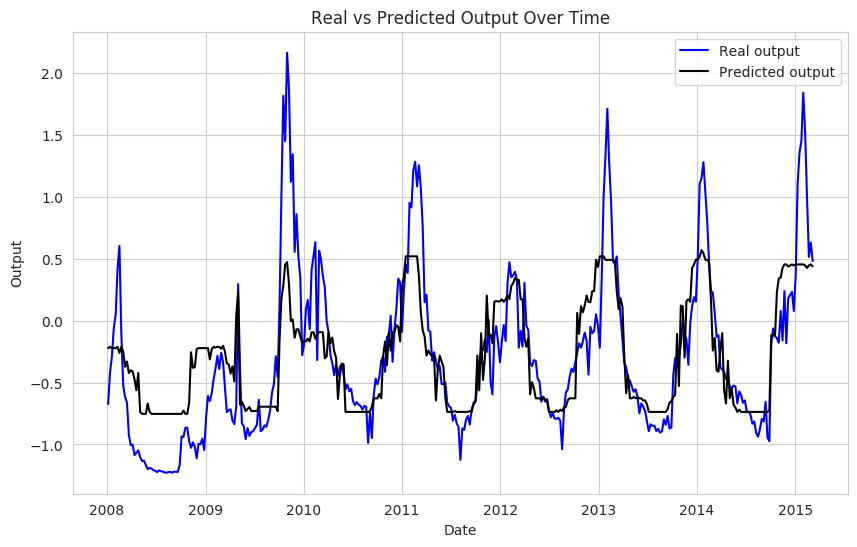

In [ ]:
print("R² on the learning set:", r2_score(y_train, rf_cv.predict(X_train)))
dates = np.array(data.index)[:len(X_train)]
pred_vs_true_train = pd.DataFrame({
    'true value': y_train,
    'predicted value': rf_cv.predict(X_train),
    'date': dates
})
pred_vs_true_train['true value'] += np.random.random_sample(len(y_train)) * 0.2 - 0.1

sns.scatterplot(data=pred_vs_true_train, x='true value', y='predicted value', alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dates, y_train, 'b', label='Real output')
plt.plot(dates, rf_cv.predict(X_train), 'black', label='Predicted output')
plt.xlabel('Date')
plt.ylabel('Output')
plt.legend()
plt.title("Real vs Predicted Output Over Time")
plt.savefig('prediction_online.png')
plt.show()


*Features based on Pearson correlation*

In [ ]:
rf_cv_1 = GridSearchCV(
    rf, rf_grid, cv=tscv, n_jobs=-1, scoring='r2'
)
rf_cv_1.fit(X_train_1, y_train_1)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50, 55, 60, 65, 70, 75, 80,
                                               85, 90, 95, 100, 105, 110, 115,
                                               120, 125, 130, 135, 140, 145, ...]},
             scoring='r2')

R² on the learning set: 0.6001194425462633


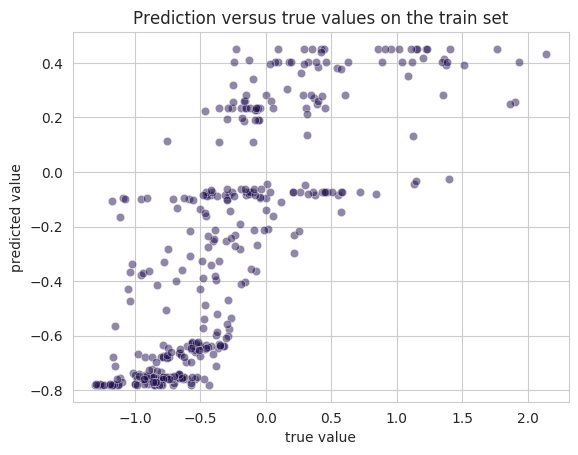

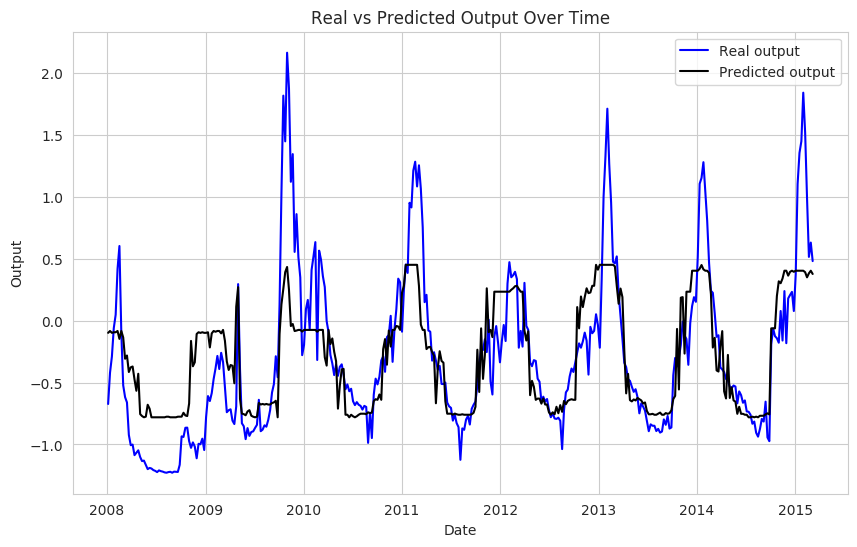

In [ ]:
print("R² on the learning set:", r2_score(y_train_1, rf_cv_1.predict(X_train_1)))
dates = np.array(data.index)[:len(X_train)]
pred_vs_true_train = pd.DataFrame({
    'true value': y_train,
    'predicted value': rf_cv_1.predict(X_train_1),
    'date': dates
})
pred_vs_true_train['true value'] += np.random.random_sample(len(y_train_1)) * 0.2 - 0.1

sns.scatterplot(data=pred_vs_true_train, x='true value', y='predicted value', alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dates, y_train_1, 'b', label='Real output')
plt.plot(dates, rf_cv_1.predict(X_train_1), 'black', label='Predicted output')
plt.xlabel('Date')
plt.ylabel('Output')
plt.legend()
plt.title("Real vs Predicted Output Over Time")
plt.savefig('prediction_online.png')
plt.show()

*Feature based on Random Forest*

In [ ]:
rf_cv_2 = GridSearchCV(
    rf, rf_grid, cv=tscv, n_jobs=-1, scoring='r2'
)
rf_cv_2.fit(X_train_2, y_train_2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50, 55, 60, 65, 70, 75, 80,
                                               85, 90, 95, 100, 105, 110, 115,
                                               120, 125, 130, 135, 140, 145, ...]},
             scoring='r2')

In [ ]:
print("R² on the learning set:", r2_score(y_train_2, rf_cv_2.predict(X_train_2)))

R² on the learning set: 0.6259480237397596


### Gradient Boosting

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=10)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2,3, 5, 7]
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,cv=tscv,
                            n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

R² on the learning set: 0.767511309957781


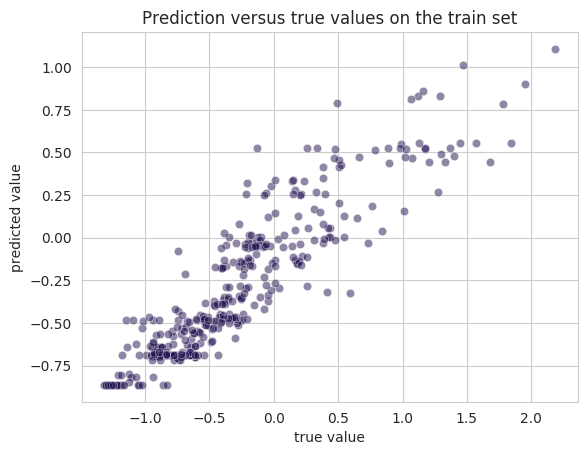

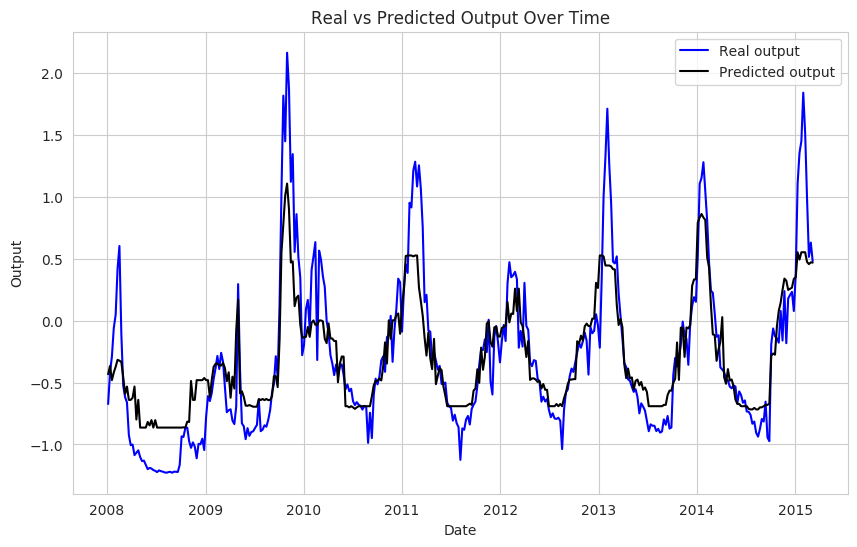

In [ ]:
print("R² on the learning set:", r2_score(y_train, grid_search.predict(X_train)))
dates = np.array(data.index)[:len(X_train)]
pred_vs_true_train = pd.DataFrame({
    'true value': y_train,
    'predicted value': grid_search.predict(X_train),
    'date': dates
})
pred_vs_true_train['true value'] += np.random.random_sample(len(y_train)) * 0.2 - 0.1

sns.scatterplot(data=pred_vs_true_train, x='true value', y='predicted value', alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dates, y_train, 'b', label='Real output')
plt.plot(dates, grid_search.predict(X_train), 'black', label='Predicted output')
plt.xlabel('Date')
plt.ylabel('Output')
plt.legend()
plt.title("Real vs Predicted Output Over Time")
plt.savefig('prediction_online.png')
plt.show()


*Features based on Pearson correlation*

In [ ]:
grid_search_1 = GridSearchCV(estimator=gbr, param_grid=param_grid,cv=tscv,
                            n_jobs=-1, scoring='r2')
grid_search_1.fit(X_train_1, y_train_1)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [ ]:
print("R² on the learning set:", r2_score(y_train_1, grid_search_1.predict(X_train_1)))

R² on the learning set: 0.563275837120156


*Feature based on Random Forest*

In [ ]:
grid_search_2 = GridSearchCV(estimator=gbr, param_grid=param_grid,cv=tscv,
                            n_jobs=-1, scoring='r2')
grid_search_2.fit(X_train_2, y_train_2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [ ]:
print("R² on the learning set:", r2_score(y_train_2, grid_search_2.predict(X_train_2)))

R² on the learning set: 0.7576930774680019


### ARX

The code for the ARX model was inspired by the following ARX model example: https://github.com/AleksandarHaber/Machine-learning-of-ARX-models-of-Dynamical-Systems-using-Keras-and-MLP/blob/master/system_identification_ARX.py

*All features*

In [ ]:
# a dropout was added to avoid overfitting
past = 3

seed_everything(1)

# Build the Keras model
model_all = Sequential()
model_all.add(Dense(2 * past, activation='relu',use_bias=False, input_dim=X_train_lagged.shape[1]))
model_all.add(Dense(1))
model_all.add(Dropout(0.2))
model_all.compile(optimizer='adam', loss='mse')


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=40, verbose=3)
history = model_all.fit(X_train_lagged, y_train_lagged, epochs=280, batch_size=20,
                    validation_data=(X_test_lagged, y_test_lagged),
                    callbacks=[lr_scheduler],
                        verbose=2)
# Evaluate the model
train_prediction = model_all.predict(X_train_lagged)
train_r2 = r2_score(y_train_lagged, train_prediction)







Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 - 1s - 55ms/step - loss: 0.6283 - val_loss: 1.5021 - learning_rate: 0.0010
Epoch 2/280
19/19 - 0s - 4ms/step - loss: 0.3832 - val_loss: 1.4693 - learning_rate: 0.0010
Epoch 3/280
19/19 - 0s - 4ms/step - loss: 0.3123 - val_loss: 1.4591 - learning_rate: 0.0010
Epoch 4/280
19/19 - 0s - 7ms/step - loss: 0.2812 - val_loss: 1.3849 - learning_rate: 0.0010
Epoch 5/280
19/19 - 0s - 4ms/step - loss: 0.2354 - val_loss: 1.3626 - learning_rate: 0.0010
Epoch 6/280
19/19 - 0s - 7ms/step - loss: 0.2349 - val_loss: 1.3358 - learning_rate: 0.0010
Epoch 7/280
19/19 - 0s - 6ms/step - loss: 0.2121 - val_loss: 1.3309 - learning_rate: 0.0010
Epoch 8/280
19/19 - 0s - 6ms/step - loss: 0.1967 - val_loss: 1.3367 - learning_rate: 0.0010
Epoch 9/280
19/19 - 0s - 8ms/step - loss: 0.1832 - val_loss: 1.3381 - learning_rate: 0.0010
Epoch 10/280
19/19 - 0s - 8ms/step - loss: 0.1686 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 11/280
19/19 - 0s - 6ms/step - loss: 0.1572 - val_loss: 1.3234 - learning_rate: 0.00

R² on the learning set: 0.9438315629959106


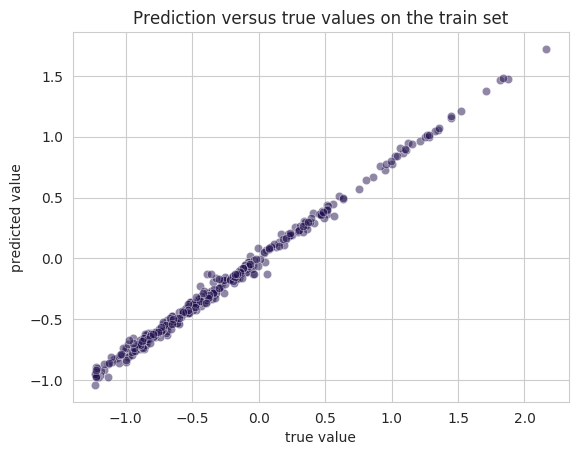

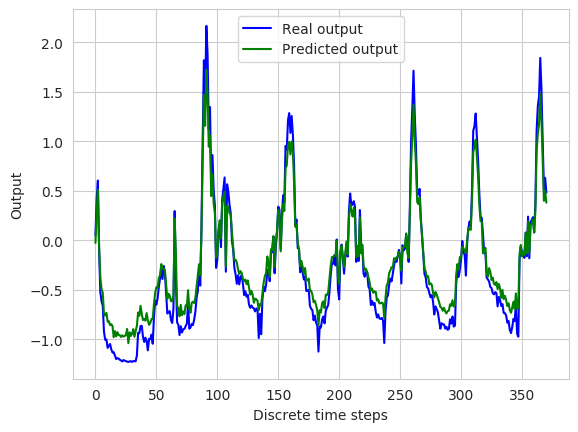

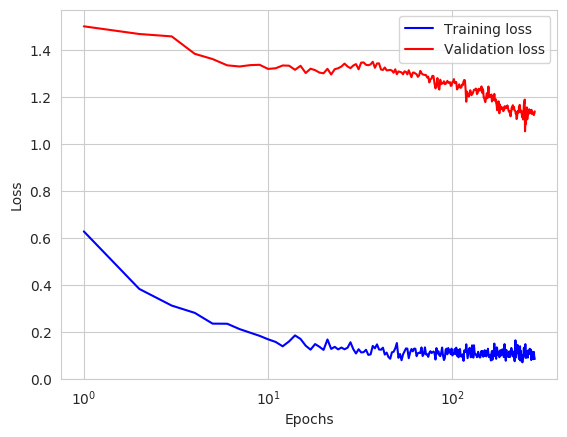

In [ ]:
print("R² on the learning set:", r2_score(y_train_lagged,train_prediction))

train_prediction = train_prediction.flatten()
Y_train_s = y_train_lagged.flatten()
pred_vs_true_train = pd.DataFrame({'true value': y_train_lagged, # target values true values
                             'predicted value':train_prediction})# prediction for train
sns.scatterplot(data=pred_vs_true_train,x='true value',y='predicted value',alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure()
plt.plot(Y_train_s, 'b', label='Real output')
plt.plot(train_prediction, 'g', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('prediction_online.png')



# Training and validation losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()
plt.savefig('loss_curves.png')

*Features based on Pearson correlation*

In [ ]:
seed_everything(1)

model = Sequential()
model.add(Dense(2 * past, activation='relu',use_bias=False, input_dim=X_train_lagged_1.shape[1]))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(optimizer='adam', loss='mse')


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
history = model.fit(X_train_lagged_1, y_train_lagged_1, epochs=280, batch_size=20,
                    validation_data=(X_test_lagged_1, y_test_lagged_1),
                    callbacks=[lr_scheduler], verbose=2)

train_prediction_1 = model.predict(X_train_lagged_1)
train_r2 = r2_score(y_train_lagged_1, train_prediction_1)



Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 - 1s - 54ms/step - loss: 0.7843 - val_loss: 1.6117 - learning_rate: 0.0010
Epoch 2/280
19/19 - 0s - 4ms/step - loss: 0.5005 - val_loss: 1.7075 - learning_rate: 0.0010
Epoch 3/280
19/19 - 0s - 8ms/step - loss: 0.4269 - val_loss: 1.6003 - learning_rate: 0.0010
Epoch 4/280
19/19 - 0s - 7ms/step - loss: 0.3962 - val_loss: 1.5383 - learning_rate: 0.0010
Epoch 5/280
19/19 - 0s - 4ms/step - loss: 0.3446 - val_loss: 1.5604 - learning_rate: 0.0010
Epoch 6/280
19/19 - 0s - 4ms/step - loss: 0.3437 - val_loss: 1.5462 - learning_rate: 0.0010
Epoch 7/280
19/19 - 0s - 4ms/step - loss: 0.3258 - val_loss: 1.5314 - learning_rate: 0.0010
Epoch 8/280
19/19 - 0s - 8ms/step - loss: 0.2838 - val_loss: 1.5137 - learning_rate: 0.0010
Epoch 9/280
19/19 - 0s - 7ms/step - loss: 0.2818 - val_loss: 1.5053 - learning_rate: 0.0010
Epoch 10/280
19/19 - 0s - 7ms/step - loss: 0.2481 - val_loss: 1.4868 - learning_rate: 0.0010
Epoch 11/280
19/19 - 0s - 8ms/step - loss: 0.2563 - val_loss: 1.5104 - learning_rate: 0.00

In [ ]:
print("R² on the learning set:", r2_score(y_train_lagged_1,train_prediction_1))


R² on the learning set: 0.7560291886329651


*Feature based on Random Forest*

In [ ]:
seed_everything(1)

model = Sequential()
model.add(Dense(2 * past, activation='relu',use_bias=False, input_dim=X_train_lagged_2.shape[1]))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(optimizer='adam', loss='mse')


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
history = model.fit(X_train_lagged_2, y_train_lagged_2, epochs=280, batch_size=20,
                    validation_data=(X_test_lagged_2, y_test_lagged_2),
                    callbacks=[lr_scheduler], verbose=2)
# Evaluate the model
train_prediction_2 = model.predict(X_train_lagged_2)
train_r2 = r2_score(y_train_lagged_2, train_prediction_2)



Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 - 1s - 50ms/step - loss: 1.0241 - val_loss: 2.0704 - learning_rate: 0.0010
Epoch 2/280
19/19 - 0s - 10ms/step - loss: 0.6254 - val_loss: 1.7838 - learning_rate: 0.0010
Epoch 3/280
19/19 - 0s - 7ms/step - loss: 0.4823 - val_loss: 1.6310 - learning_rate: 0.0010
Epoch 4/280
19/19 - 0s - 4ms/step - loss: 0.3621 - val_loss: 1.5620 - learning_rate: 0.0010
Epoch 5/280
19/19 - 0s - 6ms/step - loss: 0.3384 - val_loss: 1.5174 - learning_rate: 0.0010
Epoch 6/280
19/19 - 0s - 4ms/step - loss: 0.2926 - val_loss: 1.5056 - learning_rate: 0.0010
Epoch 7/280
19/19 - 0s - 7ms/step - loss: 0.2662 - val_loss: 1.4975 - learning_rate: 0.0010
Epoch 8/280
19/19 - 0s - 4ms/step - loss: 0.2771 - val_loss: 1.5127 - learning_rate: 0.0010
Epoch 9/280
19/19 - 0s - 7ms/step - loss: 0.2404 - val_loss: 1.5174 - learning_rate: 0.0010
Epoch 10/280
19/19 - 0s - 4ms/step - loss: 0.2454 - val_loss: 1.5238 - learning_rate: 0.0010
Epoch 11/280
19/19 - 0s - 8ms/step - loss: 0.2339 - val_loss: 1.5256 - learning_rate: 0.0

In [ ]:
print("R² on the learning set:", r2_score(y_train_lagged_2,train_prediction_2))

R² on the learning set: 0.7741684913635254


### LSTM

The code for the LSTM was inspired by the following multivariate LSTM : https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

*All features*

In [ ]:
seed_everything(1)


# Design LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(loss='mae', optimizer='adam')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
history = model.fit(train_X, train_y, epochs=280, batch_size=72, validation_data=(test_X, test_y),
                    callbacks=[lr_scheduler], verbose=2, shuffle=False)


train_prediction_3 = model.predict(train_X)
train_r2_1 = r2_score(train_y, train_prediction_3)



Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 2s - 364ms/step - loss: 0.6304 - val_loss: 0.7703 - learning_rate: 0.0010
Epoch 2/280
6/6 - 0s - 11ms/step - loss: 0.4694 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 3/280
6/6 - 0s - 13ms/step - loss: 0.4360 - val_loss: 0.8698 - learning_rate: 0.0010
Epoch 4/280
6/6 - 0s - 11ms/step - loss: 0.3785 - val_loss: 0.8311 - learning_rate: 0.0010
Epoch 5/280
6/6 - 0s - 11ms/step - loss: 0.3615 - val_loss: 0.8117 - learning_rate: 0.0010
Epoch 6/280
6/6 - 0s - 14ms/step - loss: 0.3289 - val_loss: 0.8054 - learning_rate: 0.0010
Epoch 7/280
6/6 - 0s - 23ms/step - loss: 0.3328 - val_loss: 0.8150 - learning_rate: 0.0010
Epoch 8/280
6/6 - 0s - 12ms/step - loss: 0.3049 - val_loss: 0.8066 - learning_rate: 0.0010
Epoch 9/280
6/6 - 0s - 14ms/step - loss: 0.3150 - val_loss: 0.8241 - learning_rate: 0.0010
Epoch 10/280
6/6 - 0s - 20ms/step - loss: 0.2877 - val_loss: 0.8430 - learning_rate: 0.0010
Epoch 11/280

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 - 0s 

R² on the learning set: 0.7898187209247353


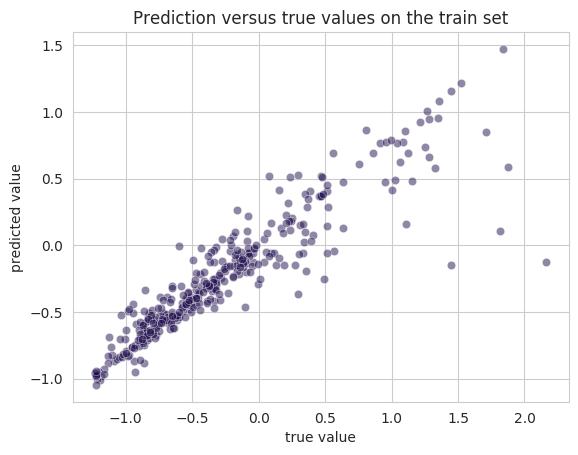

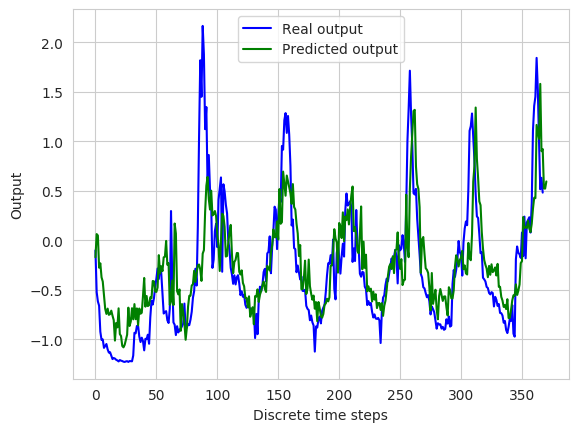

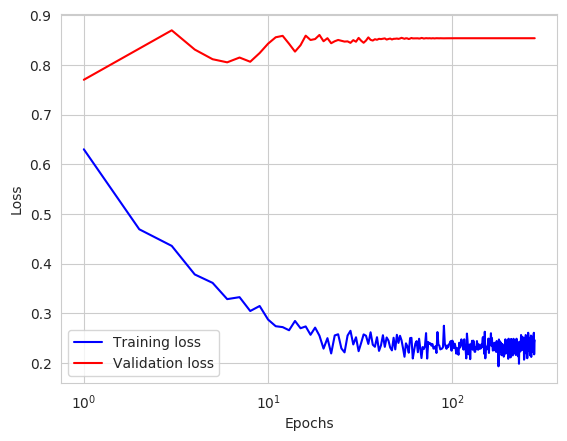

In [ ]:
print("R² on the learning set:", r2_score(train_y,train_prediction_3))

train_prediction_3 = train_prediction_3.flatten()
pred_vs_true_train = pd.DataFrame({'true value': train_y,
                             'predicted value':train_prediction_3})# prediction for train
sns.scatterplot(data=pred_vs_true_train,x='true value',y='predicted value',alpha=0.5)
plt.title("Prediction versus true values on the train set")
plt.show()

plt.figure()
plt.plot(range(len(train_y)),train_y, 'b', label='Real output')
plt.plot(train_prediction_1, 'g', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('prediction_online.png')

# Training and validation losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()
plt.savefig('loss_curves.png')

*Features based on Pearson correlation*

In [ ]:
seed_everything(1)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X_1.shape[1], train_X_1.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(loss='mae', optimizer='adam')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
history = model.fit(train_X_1, train_y_1, epochs=280, batch_size=72, validation_data=(test_X_1, test_y_1),
                    callbacks=[lr_scheduler], verbose=2, shuffle=False)


train_prediction_4 = model.predict(train_X_1)
train_r2_1 = r2_score(train_y_1, train_prediction_4)

Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 447ms/step - loss: 0.5382 - val_loss: 0.7960 - learning_rate: 0.0010
Epoch 2/280
6/6 - 0s - 50ms/step - loss: 0.4538 - val_loss: 0.7785 - learning_rate: 0.0010
Epoch 3/280
6/6 - 0s - 24ms/step - loss: 0.4195 - val_loss: 0.7852 - learning_rate: 0.0010
Epoch 4/280
6/6 - 0s - 23ms/step - loss: 0.4285 - val_loss: 0.8050 - learning_rate: 0.0010
Epoch 5/280
6/6 - 0s - 24ms/step - loss: 0.4037 - val_loss: 0.8163 - learning_rate: 0.0010
Epoch 6/280
6/6 - 0s - 18ms/step - loss: 0.4049 - val_loss: 0.8137 - learning_rate: 0.0010
Epoch 7/280
6/6 - 0s - 19ms/step - loss: 0.4026 - val_loss: 0.8031 - learning_rate: 0.0010
Epoch 8/280
6/6 - 0s - 24ms/step - loss: 0.3835 - val_loss: 0.7903 - learning_rate: 0.0010
Epoch 9/280
6/6 - 0s - 23ms/step - loss: 0.3930 - val_loss: 0.7848 - learning_rate: 0.0010
Epoch 10/280
6/6 - 0s - 23ms/step - loss: 0.3667 - val_loss: 0.7842 - learning_rate: 0.0010
Epoch 11/280
6/6 - 0s - 22ms/step - loss: 0.3635 - val_loss: 0.7830 - learning_rate: 0.0010
Epoch 12

In [ ]:
print("R² on the learning set:", r2_score(train_y_1,train_prediction_4))


R² on the learning set: 0.6312532120313953


*Feature based on Random Forest*

In [ ]:
seed_everything(1)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X_2.shape[1], train_X_2.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(loss='mae', optimizer='adam')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
history = model.fit(train_X_2, train_y_2, epochs=280, batch_size=72, validation_data=(test_X_2, test_y_2),
                    callbacks=[lr_scheduler], verbose=2, shuffle=False)


train_prediction_5 = model.predict(train_X_2)
train_r2_1 = r2_score(train_y_2, train_prediction_5)

Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 2s - 353ms/step - loss: 0.5732 - val_loss: 0.8811 - learning_rate: 0.0010
Epoch 2/280
6/6 - 0s - 10ms/step - loss: 0.4791 - val_loss: 0.8607 - learning_rate: 0.0010
Epoch 3/280
6/6 - 0s - 10ms/step - loss: 0.4211 - val_loss: 0.8478 - learning_rate: 0.0010
Epoch 4/280
6/6 - 0s - 13ms/step - loss: 0.4012 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 5/280
6/6 - 0s - 11ms/step - loss: 0.3916 - val_loss: 0.8456 - learning_rate: 0.0010
Epoch 6/280
6/6 - 0s - 18ms/step - loss: 0.3699 - val_loss: 0.8470 - learning_rate: 0.0010
Epoch 7/280
6/6 - 0s - 11ms/step - loss: 0.3758 - val_loss: 0.8470 - learning_rate: 0.0010
Epoch 8/280
6/6 - 0s - 26ms/step - loss: 0.3578 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 9/280
6/6 - 0s - 22ms/step - loss: 0.3637 - val_loss: 0.8440 - learning_rate: 0.0010
Epoch 10/280
6/6 - 0s - 23ms/step - loss: 0.3529 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 11/280
6/6 - 0s - 11ms/step - loss: 0.3456 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 12

In [ ]:
print("R² on the learning set:", r2_score(train_y_2,train_prediction_5))


R² on the learning set: 0.7727254070766065


## Final Results

From our learning set results the best results are obtained using the Random Forest model with the Random forest features.

In [ ]:
x_test_lagged_fourw = X_test_lagged[:8]
y_test_lagged_fourw = y_test_lagged[:8]


In [ ]:
prediction= model_all.predict(X_test_lagged)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
print("R² on the learning set:", r2_score(y_test_lagged,prediction))


R² on the learning set: 0.26450544595718384


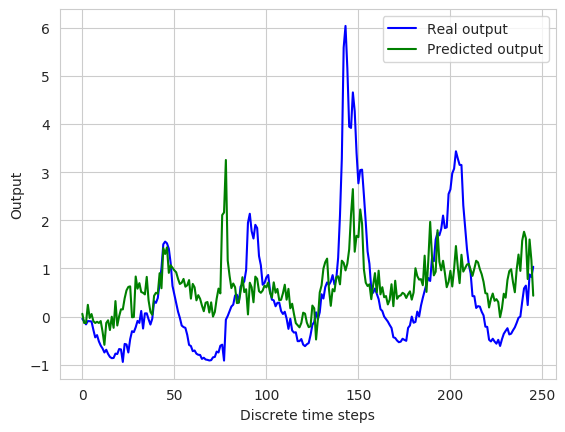

In [ ]:
plt.figure()
plt.plot(y_test_lagged, 'b', label='Real output')
plt.plot(prediction, 'g', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('prediction_online.png')

In [ ]:
x_test_lagged_fourw = X_test_lagged[40:45]
y_test_lagged_fourw = y_test_lagged[40:45]

In [ ]:
prediction= model_all.predict(x_test_lagged_fourw)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
print("R² on the learning set:", r2_score(y_test_lagged_fourw,prediction))


R² on the learning set: 0.7239187955856323


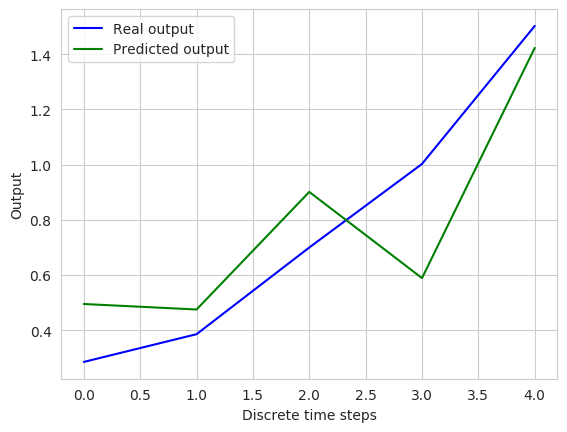

In [ ]:
plt.figure()
plt.plot(y_test_lagged_fourw, 'b', label='Real output')
plt.plot(prediction, 'g', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('prediction_online.png')